# TinyTimeMixers Forecasting (Unsmoothed Data)
- IBM Documentation used: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/
- Github Copilot was used to aid in code generation in this notebook

In [56]:
# Get the Granite TSFM repository from GitHub
!git clone "https://github.com/ibm-granite/granite-tsfm.git"

fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [57]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases API Key needed for this notebook (can be obtained at https://wandb.ai)

In [58]:
# Load datasets
with open('../../data/processed_data_pickle_files_no_smoothing/test_data_no_batches.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('../../data/processed_data_pickle_files_no_smoothing/test_data_no_batches.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

column_names = ['unit_number', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21']

train_df.columns = column_names

In [59]:
print(train_df.head(20))

    unit_number  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  \
0           1.0  0.678077 -0.853550 -1.191480  0.141683  0.601408 -0.798093   
1           1.0 -1.941707 -0.338137 -1.501467  0.141683  1.674769 -1.220725   
2           1.0 -0.441831 -0.584426 -0.843717  0.141683  0.838677 -0.657216   
3           1.0 -0.481827 -1.044384 -0.279297  0.141683  0.793483 -0.938970   
4           1.0 -0.341839 -0.543650 -0.779276  0.141683  0.895170 -1.220725   
5           1.0 -1.141773 -1.859911 -1.533688  0.141683  0.962961 -1.361602   
6           1.0 -1.141773 -1.171606 -0.454845  0.141683  0.590110 -0.657216   
7           1.0 -0.281844 -1.571215 -0.893715  0.141683  0.251154 -0.657216   
8           1.0 -1.601735  0.451294  0.371786  0.141683  1.268021 -0.516338   
9           1.0 -1.221767 -0.860075 -1.143704  0.141683  1.030752 -0.798093   
10          1.0 -1.281762 -1.548380 -0.567062  0.141683  1.493992 -0.798093   
11          1.0 -0.281844 -0.504505 -1.234812  0.141

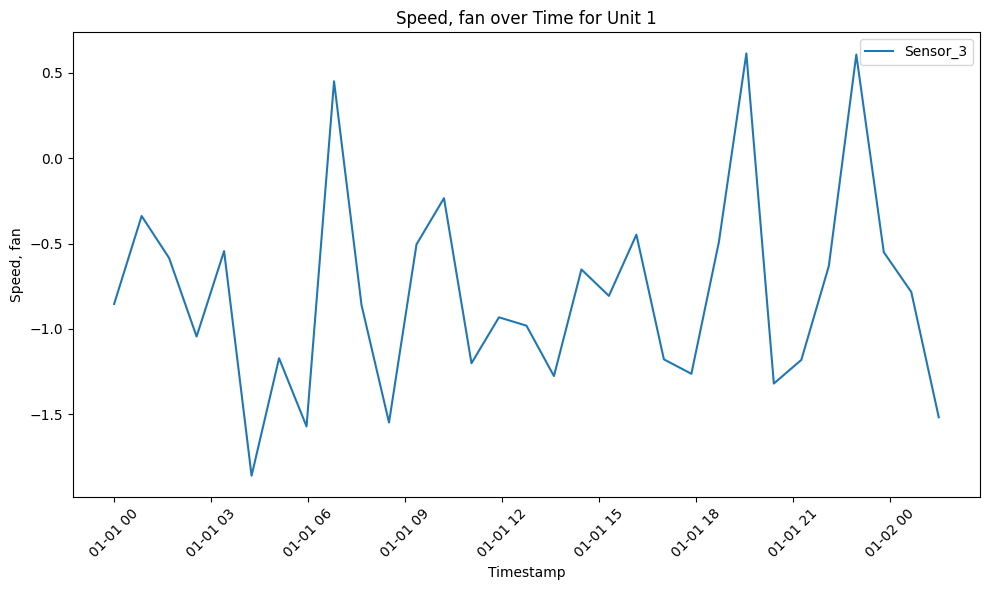

In [60]:
# Step 1 & 2: Efficiently add empty rows and timestamp for each unit_number
def expand_and_add_timestamp(df, num_empty_rows=50, start_date='2023-01-01'):
    dfs = []
    for unit_num, group in df.groupby('unit_number'):
        N = len(group)
        total_rows = N + (N - 1) * num_empty_rows
        # Create timestamps starting at midnight for each unit_number
        timestamps = pd.date_range(start=start_date, periods=total_rows, freq='min')
        # Create an empty DataFrame with timestamps
        expanded_group = pd.DataFrame({'timestamp': timestamps})
        # Calculate positions to insert the original data
        positions = np.arange(N) * (num_empty_rows + 1)
        # Assign unit_number to the expanded DataFrame
        expanded_group['unit_number'] = unit_num
        # Insert the original data into the correct positions
        expanded_group.loc[positions, group.columns] = group.values
        dfs.append(expanded_group)
    expanded_df = pd.concat(dfs, ignore_index=True)
    return expanded_df

# Step 3: Interpolate the missing values for each unit_number
def interpolate_missing_values(df):
    df = df.set_index(['unit_number', 'timestamp'])
    df = df.interpolate(method='linear')
    df = df.reset_index()
    return df


# Apply the steps to train_df
train_df = expand_and_add_timestamp(train_df)
train_df = interpolate_missing_values(train_df)

# Step 4: Plot 'Speed, fan' for unit_number = 1 over timestamp column
unit_1_data = train_df[train_df['unit_number'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_1_data['timestamp'], unit_1_data['sensor_3'], label='Sensor_3')
plt.xlabel('Timestamp')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time for Unit 1')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Refine dataset
train_df = train_df.dropna()
train_df.columns

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21'],
      dtype='object')

# Forecasting

In [62]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [63]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, delta):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][delta - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][delta - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [64]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05 # 5% of the data can be used for few-shot
prediction_filter = 24 # Filter this many predicted time points

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["sensor_2"]
observable_columns = train_df.columns[3:]

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

{'train': [0, 1225], 'valid': [713, 1378], 'test': [866, 1530]}
1531
Dataset for unit 1 is good


  0%|          | 0/72 [00:00<?, ?it/s]

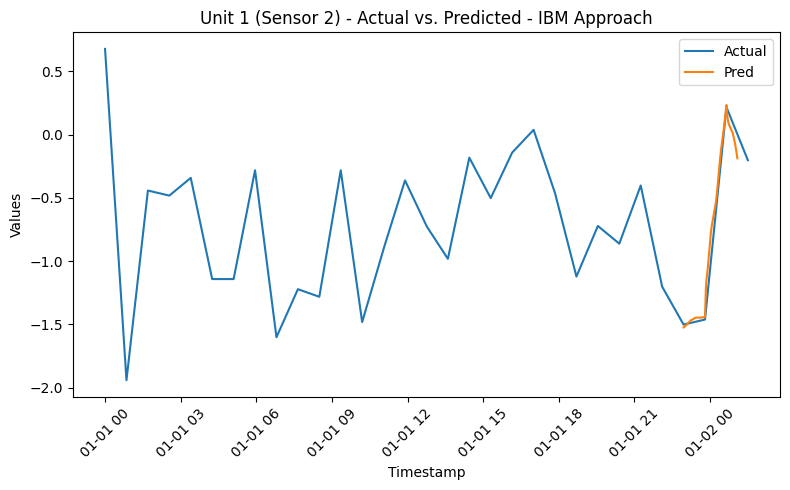

RMSE for Unit 1 - sensor_2: 0.37901007055356317
{'train': [0, 1959], 'valid': [1447, 2204], 'test': [1692, 2448]}
2449
Dataset for unit 2 is good


  0%|          | 0/83 [00:00<?, ?it/s]

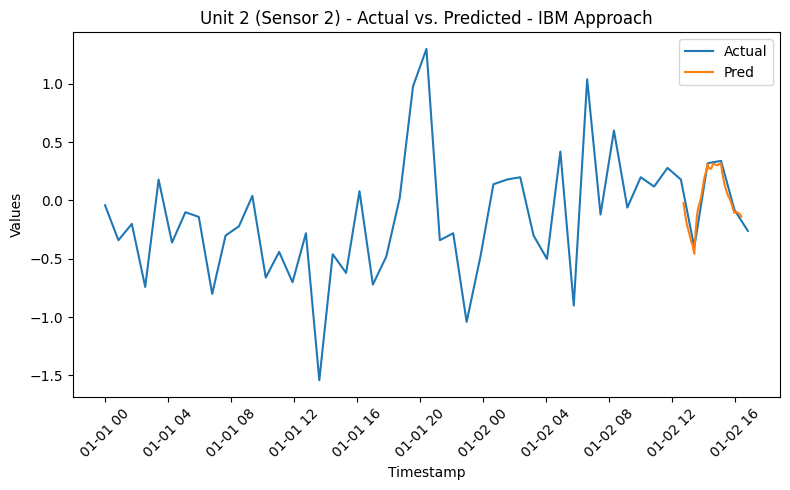

RMSE for Unit 2 - sensor_2: 0.14879887350053825
{'train': [0, 5101], 'valid': [4589, 5738], 'test': [5226, 6375]}
6376
Dataset for unit 3 is good


  0%|          | 0/132 [00:00<?, ?it/s]

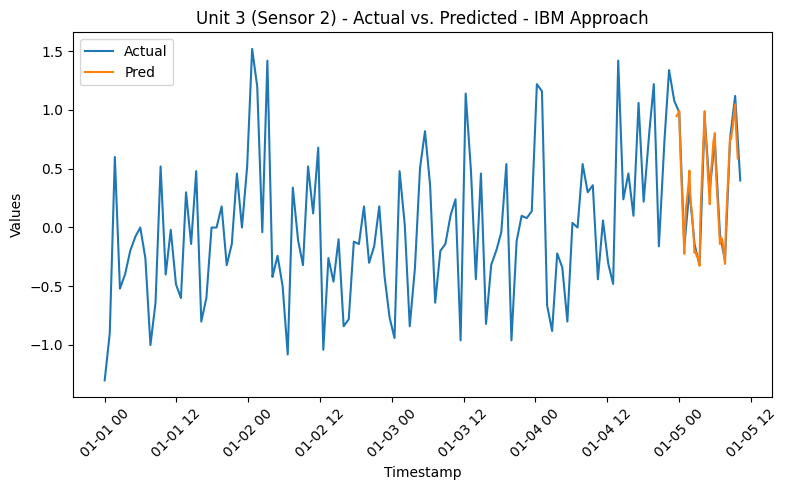

RMSE for Unit 3 - sensor_2: 0.2612263870929705
{'train': [0, 4285], 'valid': [3773, 4820], 'test': [4308, 5355]}
5356
Dataset for unit 4 is good


  0%|          | 0/119 [00:00<?, ?it/s]

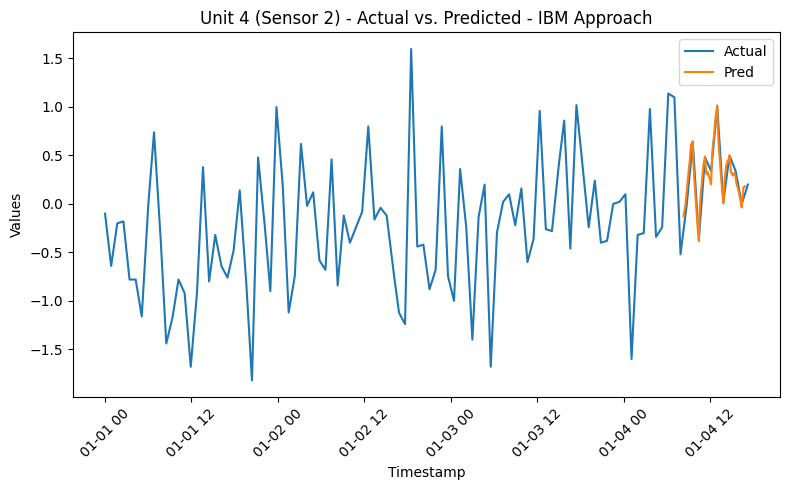

RMSE for Unit 4 - sensor_2: 0.19595725262375688
{'train': [0, 3958], 'valid': [3446, 4453], 'test': [3941, 4947]}
4948
Dataset for unit 5 is good


  0%|          | 0/114 [00:00<?, ?it/s]

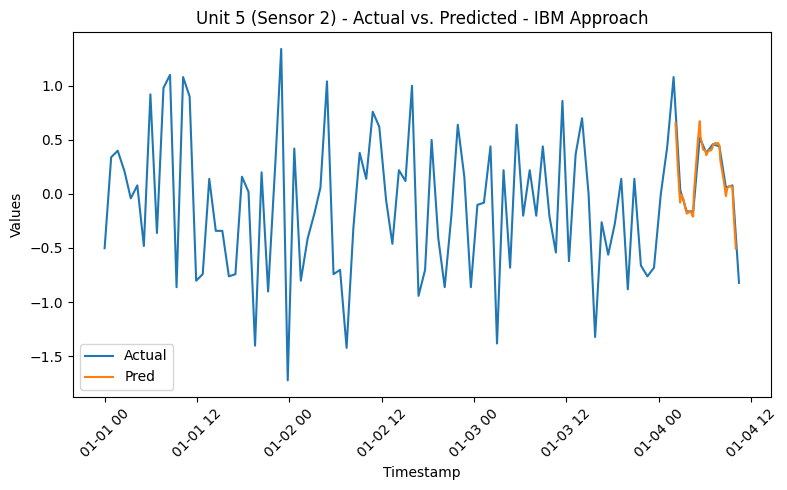

RMSE for Unit 5 - sensor_2: 0.15108531597081015
{'train': [0, 4244], 'valid': [3732, 4774], 'test': [4262, 5304]}
5305
Dataset for unit 6 is good


  0%|          | 0/119 [00:00<?, ?it/s]

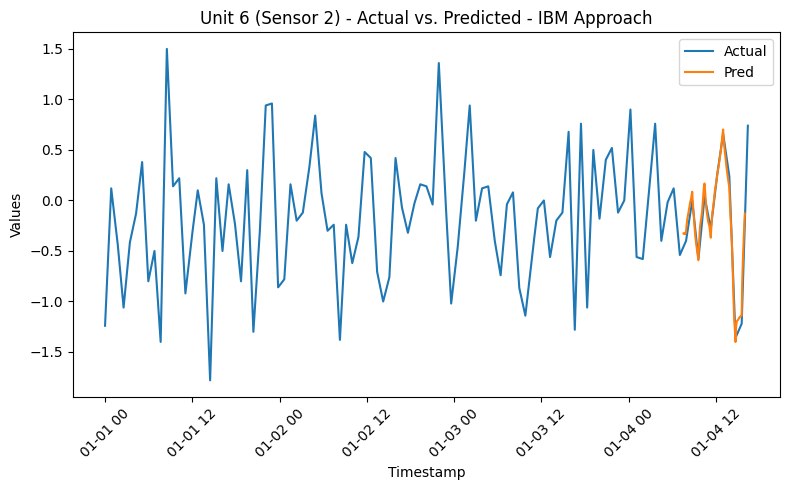

RMSE for Unit 6 - sensor_2: 0.3143825270378965
{'train': [0, 6488], 'valid': [5976, 7299], 'test': [6787, 8109]}
8110
Dataset for unit 7 is good


  0%|          | 0/154 [00:00<?, ?it/s]

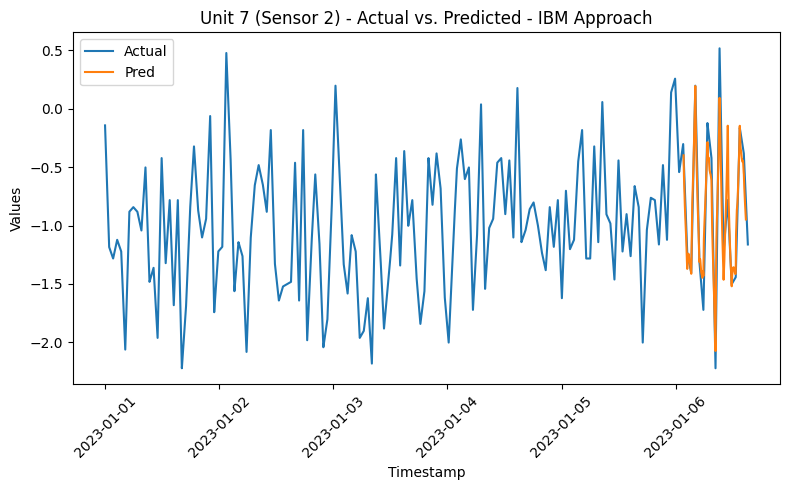

RMSE for Unit 7 - sensor_2: 0.42422390256811604
{'train': [0, 6733], 'valid': [6221, 7574], 'test': [7062, 8415]}
8416
Dataset for unit 8 is good


  0%|          | 0/158 [00:00<?, ?it/s]

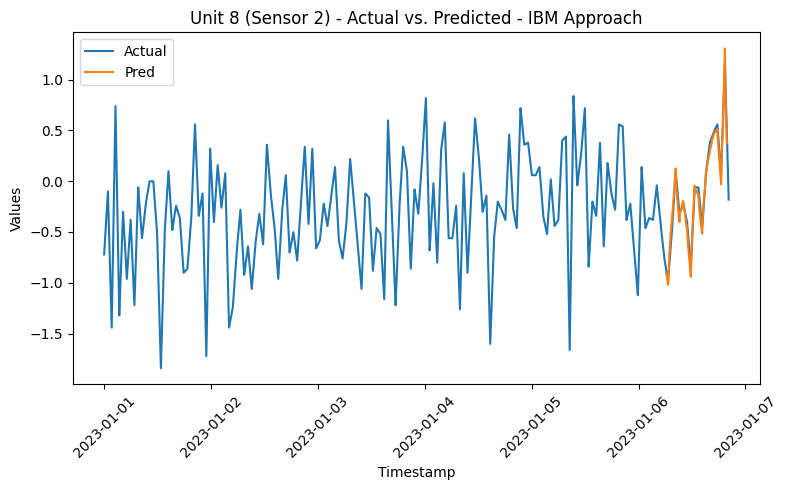

RMSE for Unit 8 - sensor_2: 0.21521637485124281
{'train': [0, 2204], 'valid': [1692, 2480], 'test': [1968, 2754]}
2755
Dataset for unit 9 is good


  0%|          | 0/87 [00:00<?, ?it/s]

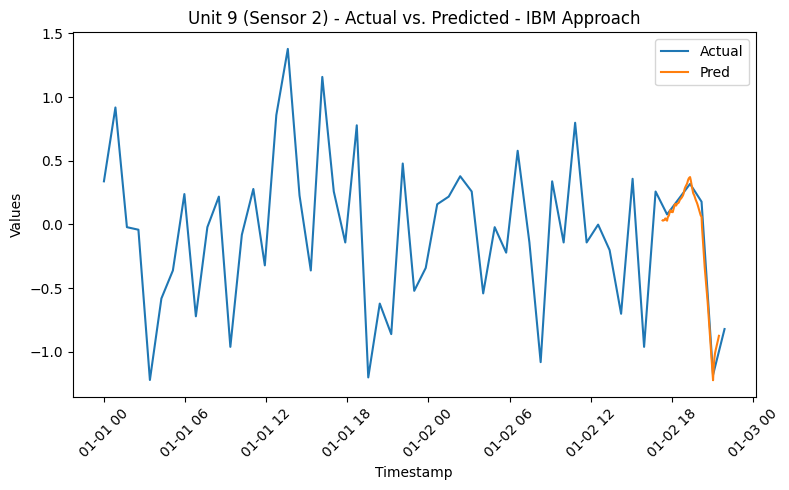

RMSE for Unit 9 - sensor_2: 0.22181848163694232
{'train': [0, 7794], 'valid': [7282, 8768], 'test': [8256, 9741]}
9742
Dataset for unit 10 is good


  0%|          | 0/174 [00:00<?, ?it/s]

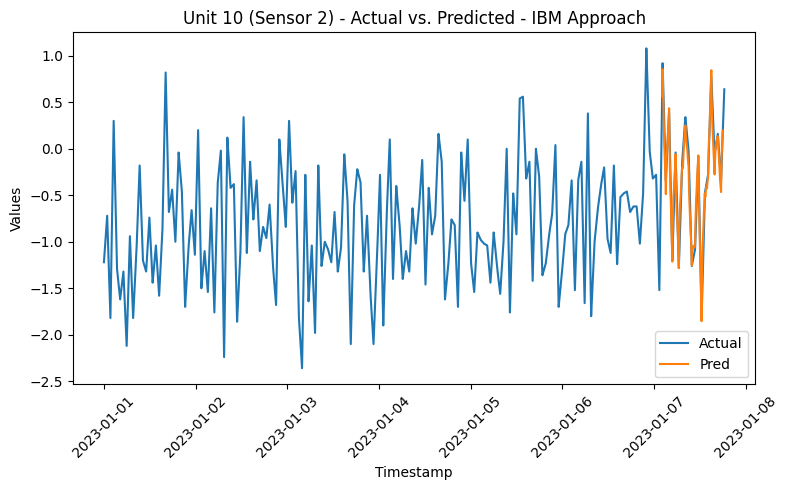

RMSE for Unit 10 - sensor_2: 0.3379518172491543
{'train': [0, 3346], 'valid': [2834, 3765], 'test': [3253, 4182]}
4183
Dataset for unit 11 is good


  0%|          | 0/105 [00:00<?, ?it/s]

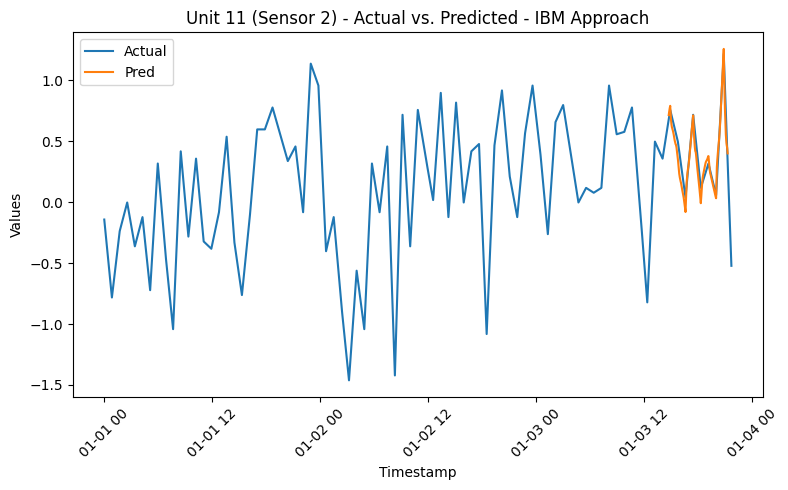

RMSE for Unit 11 - sensor_2: 0.29744506482787253
{'train': [0, 8814], 'valid': [8302, 9915], 'test': [9403, 11016]}
11017
Dataset for unit 12 is good


  0%|          | 0/190 [00:00<?, ?it/s]

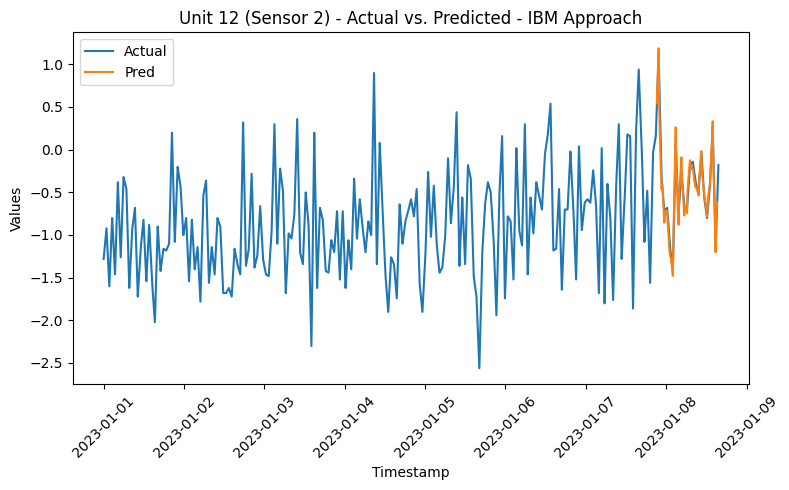

RMSE for Unit 12 - sensor_2: 0.24795164482759993
{'train': [0, 7916], 'valid': [7404, 8906], 'test': [8394, 9894]}
9895
Dataset for unit 13 is good


  0%|          | 0/176 [00:00<?, ?it/s]

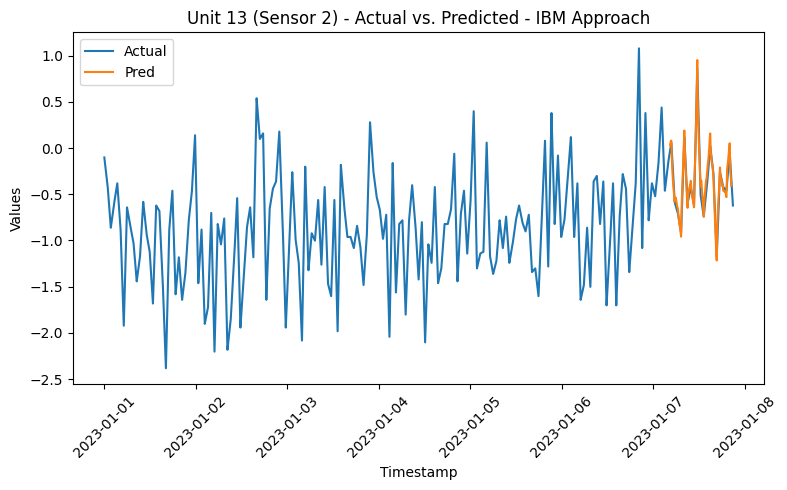

RMSE for Unit 13 - sensor_2: 0.25544408621529
{'train': [0, 1837], 'valid': [1325, 2066], 'test': [1554, 2295]}
2296
Dataset for unit 14 is good


  0%|          | 0/81 [00:00<?, ?it/s]

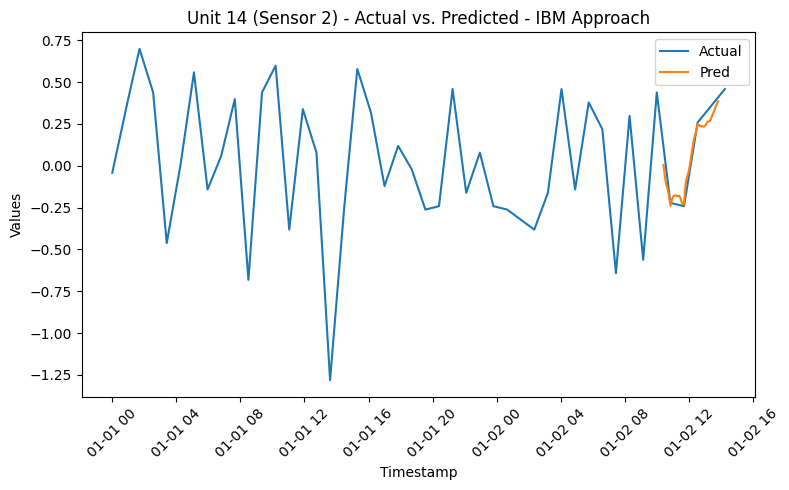

RMSE for Unit 14 - sensor_2: 0.1200909048501793
{'train': [0, 3061], 'valid': [2549, 3443], 'test': [2931, 3825]}
3826
Dataset for unit 15 is good


  0%|          | 0/100 [00:00<?, ?it/s]

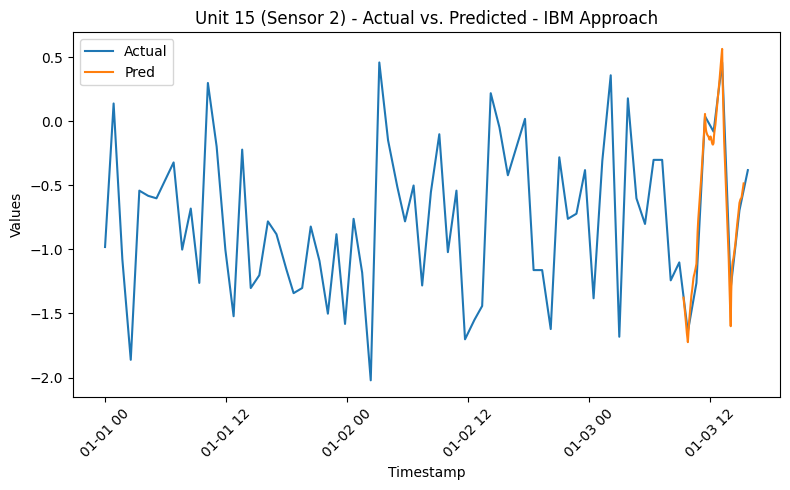

RMSE for Unit 15 - sensor_2: 0.3259786364088139
{'train': [0, 4570], 'valid': [4058, 5142], 'test': [4630, 5712]}
5713
Dataset for unit 16 is good


  0%|          | 0/124 [00:00<?, ?it/s]

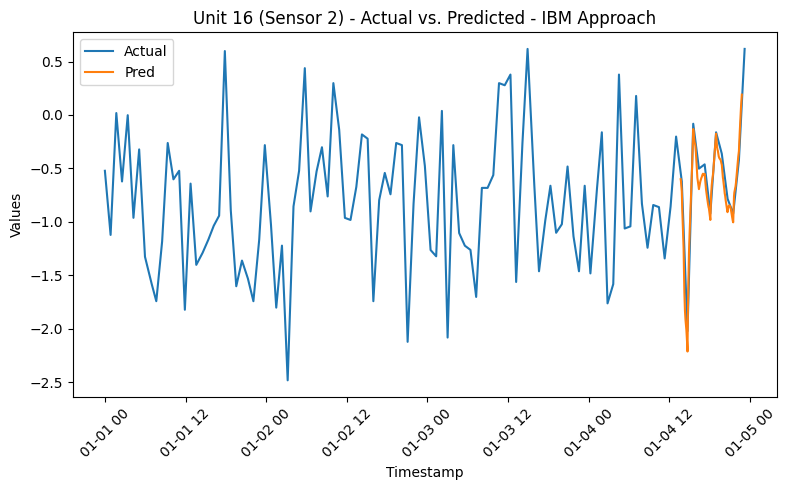

RMSE for Unit 16 - sensor_2: 0.3042997341413642
{'train': [0, 6692], 'valid': [6180, 7528], 'test': [7016, 8364]}
8365
Dataset for unit 17 is good


  0%|          | 0/157 [00:00<?, ?it/s]

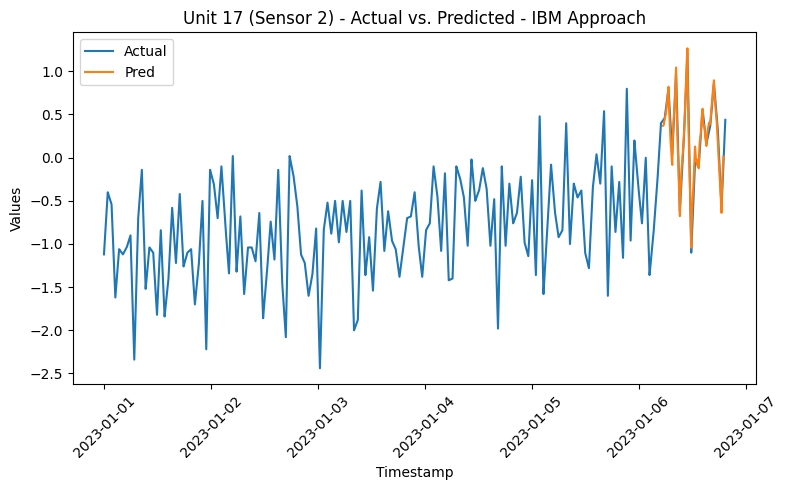

RMSE for Unit 17 - sensor_2: 0.34421543614026096
{'train': [0, 5386], 'valid': [4874, 6060], 'test': [5548, 6732]}
6733
Dataset for unit 18 is good


  0%|          | 0/137 [00:00<?, ?it/s]

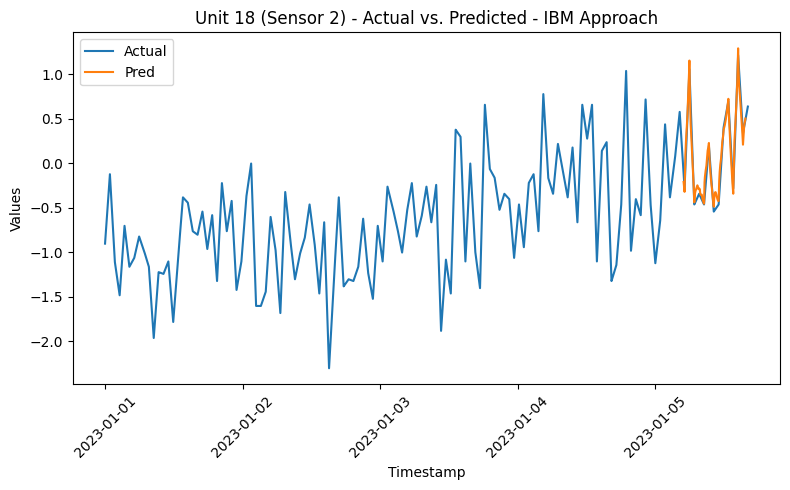

RMSE for Unit 18 - sensor_2: 0.31462216264023435
{'train': [0, 5468], 'valid': [4956, 6152], 'test': [5640, 6834]}
6835
Dataset for unit 19 is good


  0%|          | 0/138 [00:00<?, ?it/s]

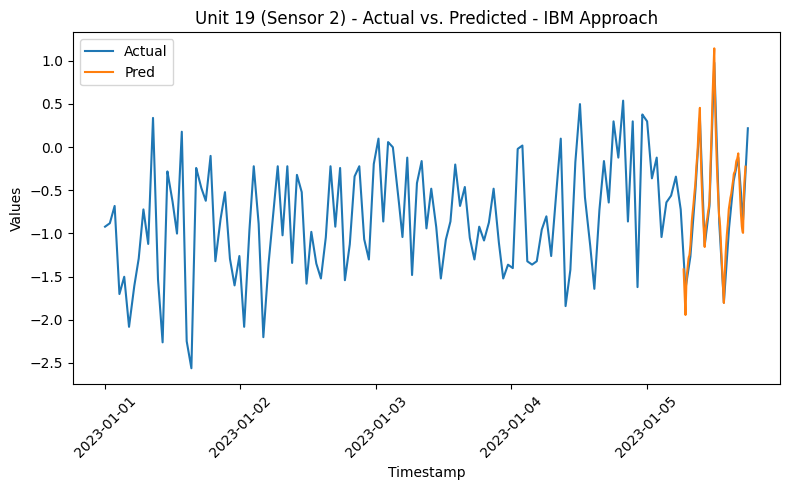

RMSE for Unit 19 - sensor_2: 0.371143852275788
{'train': [0, 7467], 'valid': [6955, 8401], 'test': [7889, 9333]}
9334
Dataset for unit 20 is good


  0%|          | 0/169 [00:00<?, ?it/s]

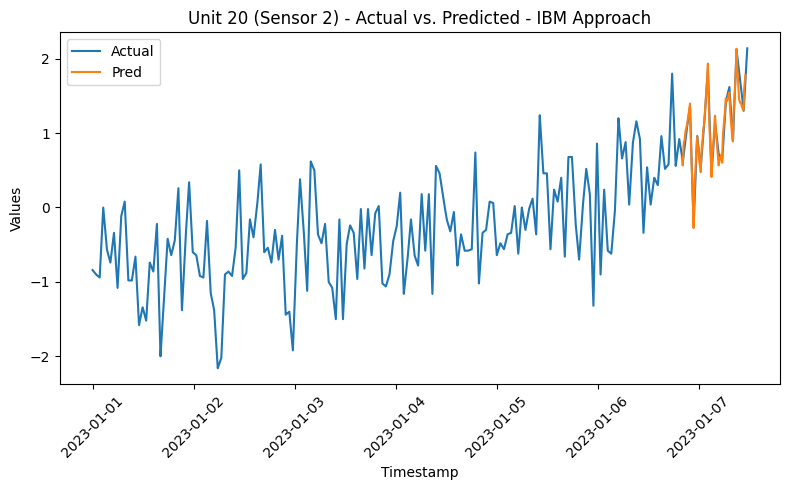

RMSE for Unit 20 - sensor_2: 0.28422935465916876
{'train': [0, 5998], 'valid': [5486, 6748], 'test': [6236, 7497]}
7498
Dataset for unit 21 is good


  0%|          | 0/146 [00:00<?, ?it/s]

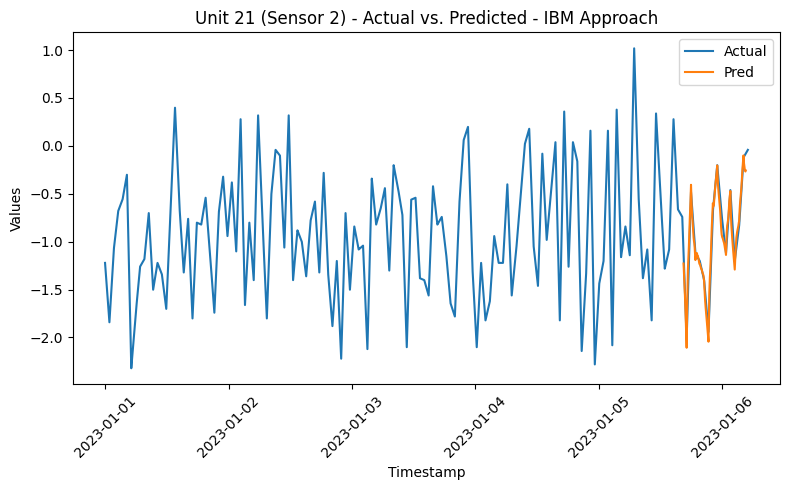

RMSE for Unit 21 - sensor_2: 0.24820761912033493
{'train': [0, 1551], 'valid': [1039, 1745], 'test': [1233, 1938]}
1939
Dataset for unit 22 is good


  0%|          | 0/77 [00:00<?, ?it/s]

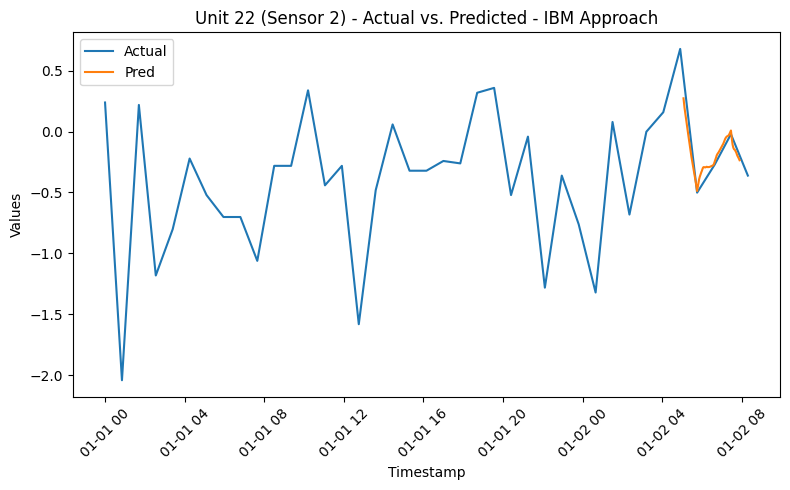

RMSE for Unit 22 - sensor_2: 0.16802394480966398
{'train': [0, 5264], 'valid': [4752, 5922], 'test': [5410, 6579]}
6580
Dataset for unit 23 is good


  0%|          | 0/135 [00:00<?, ?it/s]

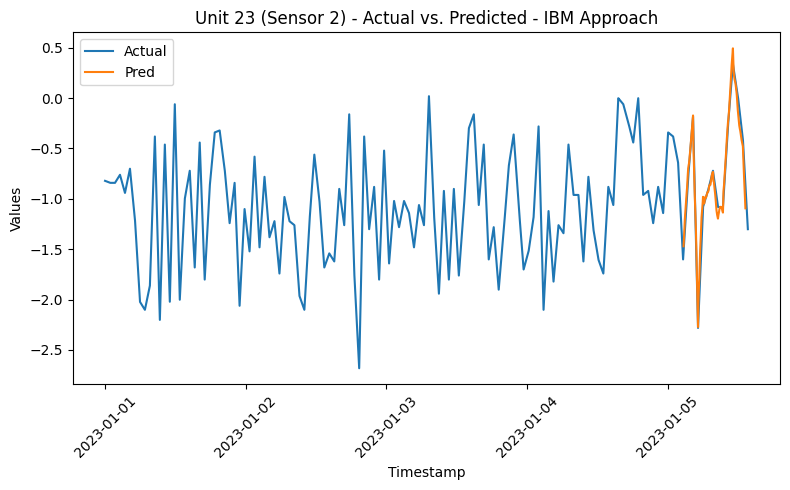

RMSE for Unit 23 - sensor_2: 0.3072113755568286
{'train': [0, 7549], 'valid': [7037, 8492], 'test': [7980, 9435]}
9436
Dataset for unit 24 is good


  0%|          | 0/170 [00:00<?, ?it/s]

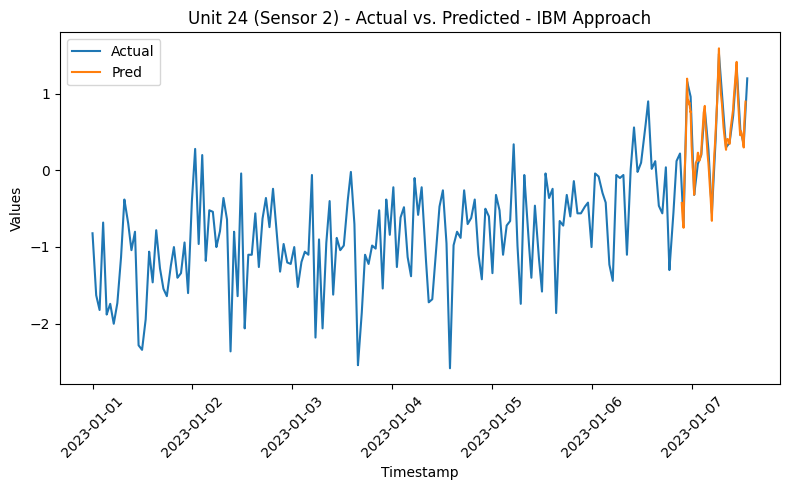

RMSE for Unit 24 - sensor_2: 0.27841344539071977
{'train': [0, 1918], 'valid': [1406, 2158], 'test': [1646, 2397]}
2398
Dataset for unit 25 is good


  0%|          | 0/82 [00:00<?, ?it/s]

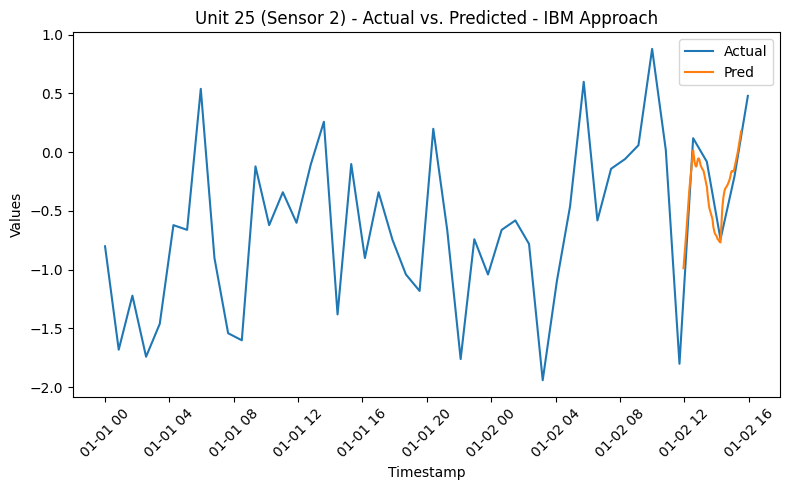

RMSE for Unit 25 - sensor_2: 0.25482100629972243
{'train': [0, 3061], 'valid': [2549, 3443], 'test': [2931, 3825]}
3826
Dataset for unit 26 is good


  0%|          | 0/100 [00:00<?, ?it/s]

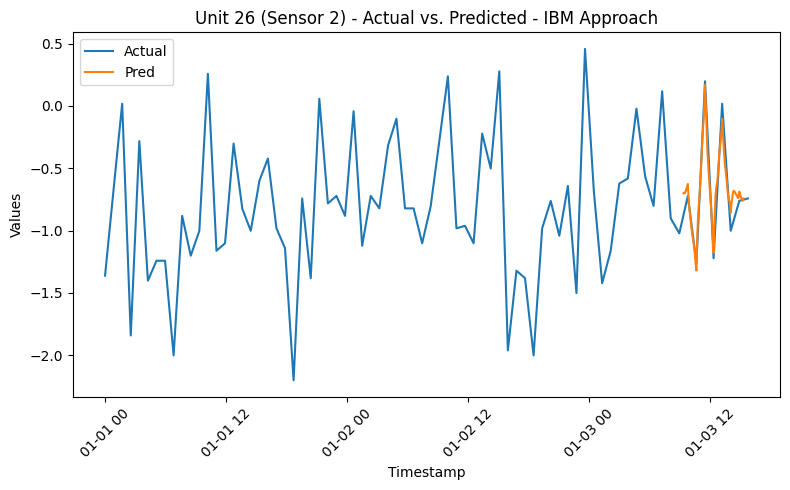

RMSE for Unit 26 - sensor_2: 0.35015822946692743
{'train': [0, 5672], 'valid': [5160, 6381], 'test': [5869, 7089]}
7090
Dataset for unit 27 is good


  0%|          | 0/141 [00:00<?, ?it/s]

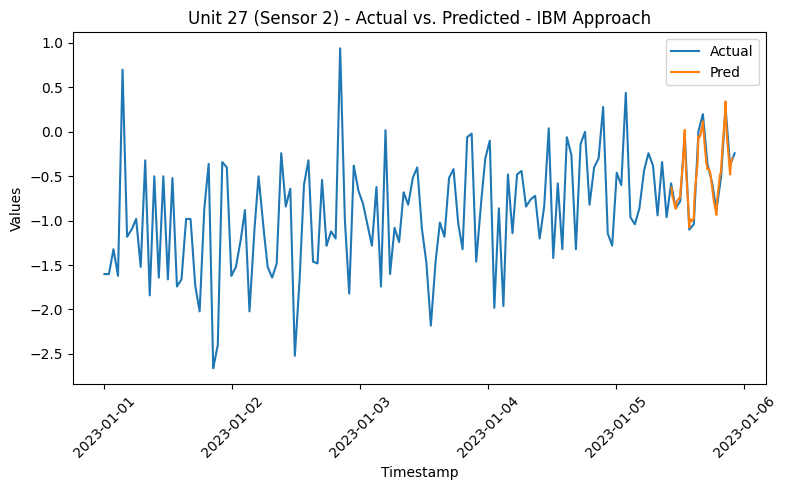

RMSE for Unit 27 - sensor_2: 0.2155385659039652
{'train': [0, 6406], 'valid': [5894, 7207], 'test': [6695, 8007]}
8008
Dataset for unit 28 is good


  0%|          | 0/153 [00:00<?, ?it/s]

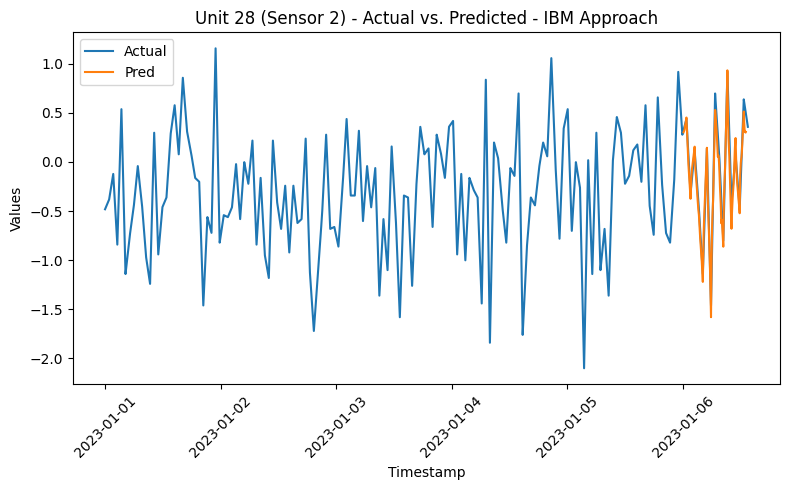

RMSE for Unit 28 - sensor_2: 0.39552162175091976
{'train': [0, 6937], 'valid': [6425, 7804], 'test': [7292, 8670]}
8671
Dataset for unit 29 is good


  0%|          | 0/161 [00:00<?, ?it/s]

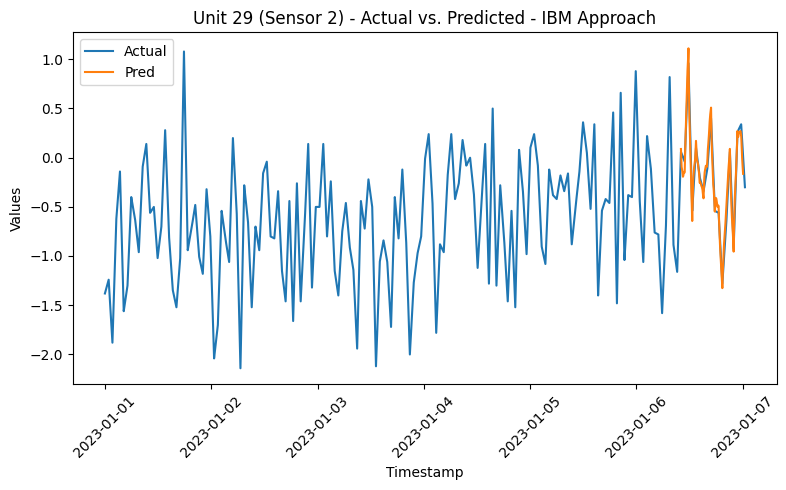

RMSE for Unit 29 - sensor_2: 0.26693372076527017
{'train': [0, 5794], 'valid': [5282, 6519], 'test': [6007, 7242]}
7243
Dataset for unit 30 is good


  0%|          | 0/143 [00:00<?, ?it/s]

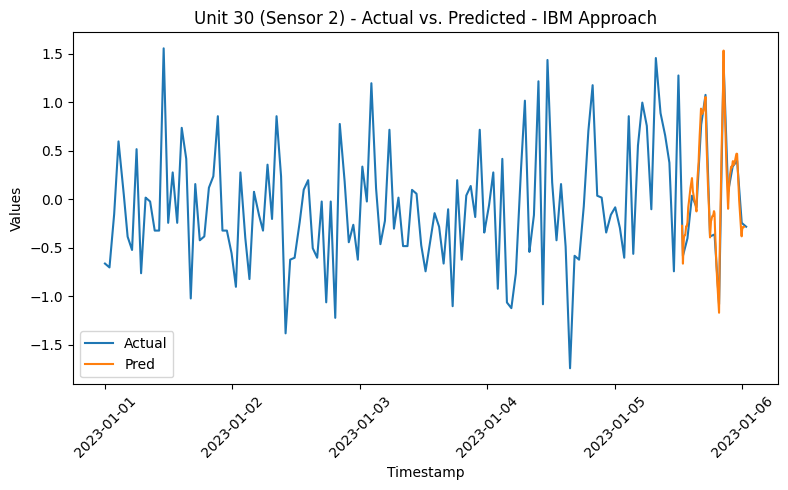

RMSE for Unit 30 - sensor_2: 0.3508930414417197
{'train': [0, 7957], 'valid': [7445, 8951], 'test': [8439, 9945]}
9946
Dataset for unit 31 is good


  0%|          | 0/177 [00:00<?, ?it/s]

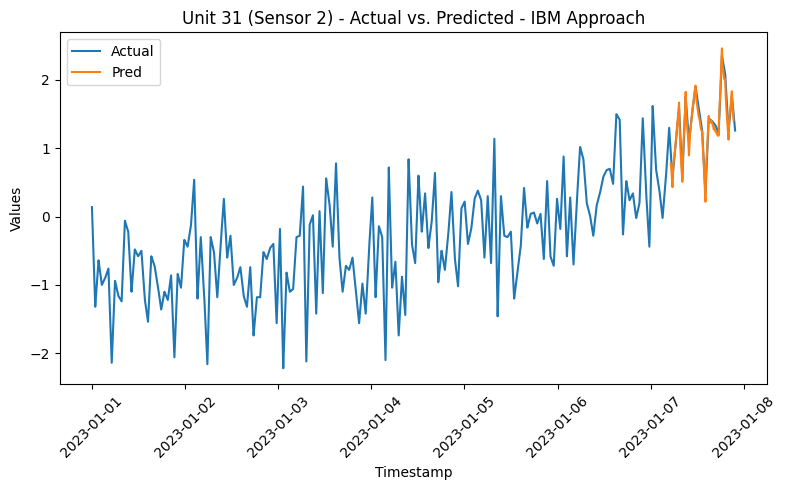

RMSE for Unit 31 - sensor_2: 0.24515719095991814
{'train': [0, 5876], 'valid': [5364, 6610], 'test': [6098, 7344]}
7345
Dataset for unit 32 is good


  0%|          | 0/144 [00:00<?, ?it/s]

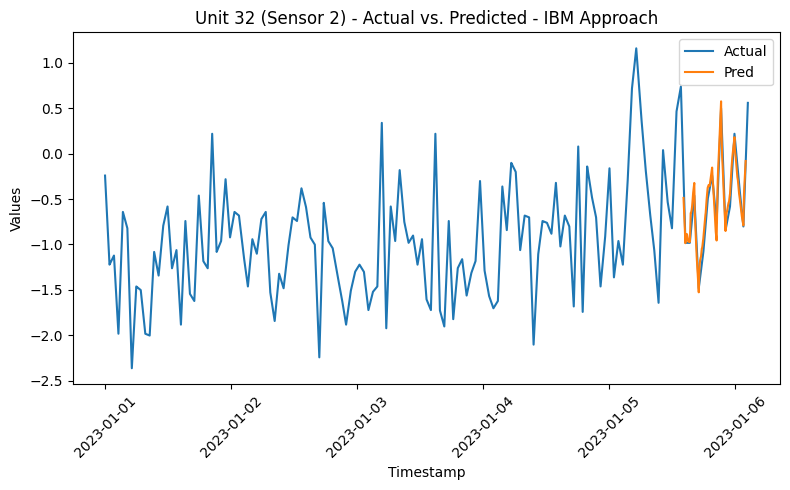

RMSE for Unit 32 - sensor_2: 0.266883973398755
{'train': [0, 2000], 'valid': [1488, 2250], 'test': [1738, 2499]}
2500
Dataset for unit 33 is good


  0%|          | 0/84 [00:00<?, ?it/s]

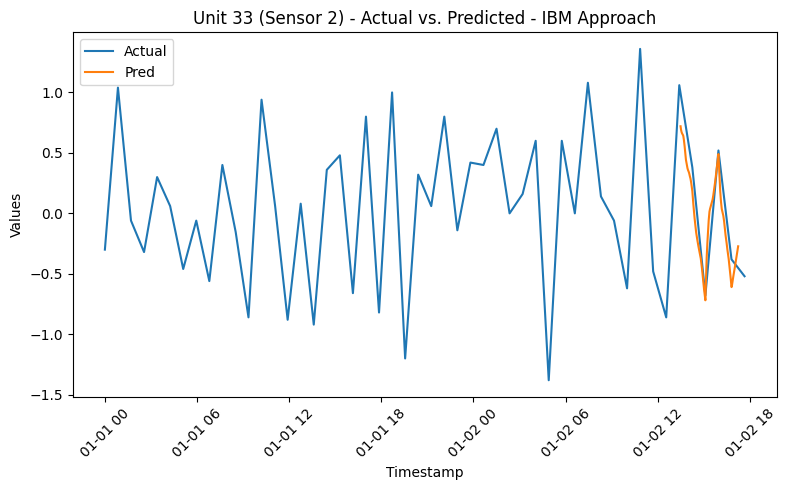

RMSE for Unit 33 - sensor_2: 0.23623321797570732
{'train': [0, 8242], 'valid': [7730, 9273], 'test': [8761, 10302]}
10303
Dataset for unit 34 is good


  0%|          | 0/181 [00:00<?, ?it/s]

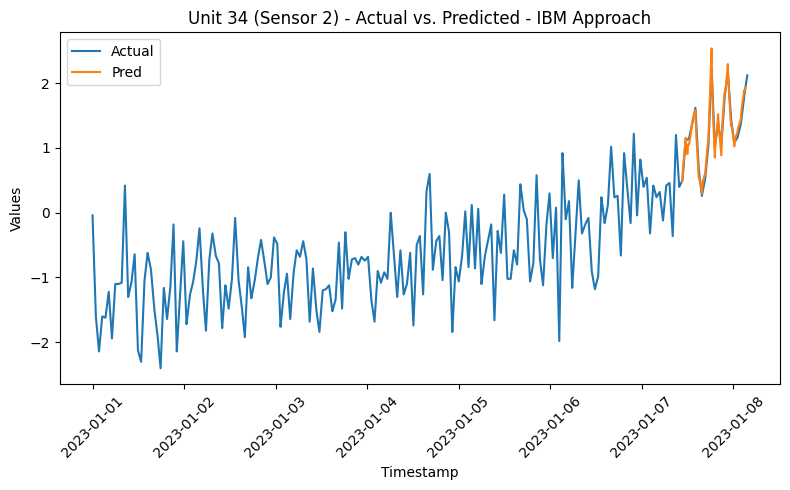

RMSE for Unit 34 - sensor_2: 0.2165357045518528
{'train': [0, 8038], 'valid': [7526, 9043], 'test': [8531, 10047]}
10048
Dataset for unit 35 is good


  0%|          | 0/178 [00:00<?, ?it/s]

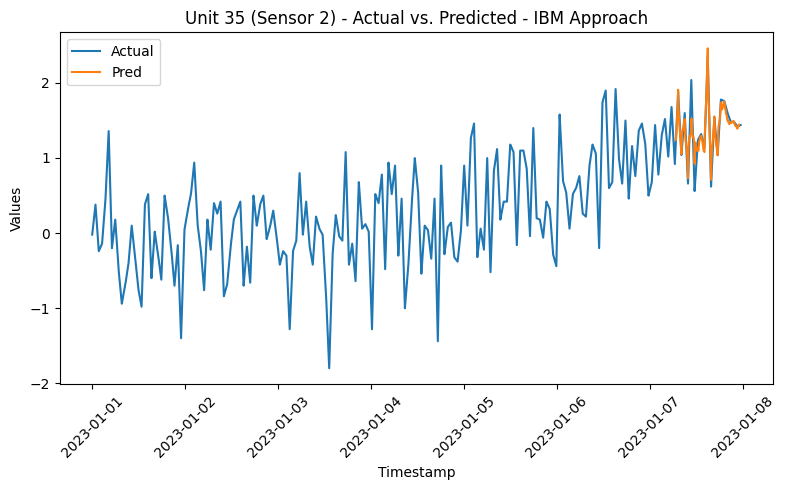

RMSE for Unit 35 - sensor_2: 0.2915722604413938
{'train': [0, 5101], 'valid': [4589, 5738], 'test': [5226, 6375]}
6376
Dataset for unit 36 is good


  0%|          | 0/132 [00:00<?, ?it/s]

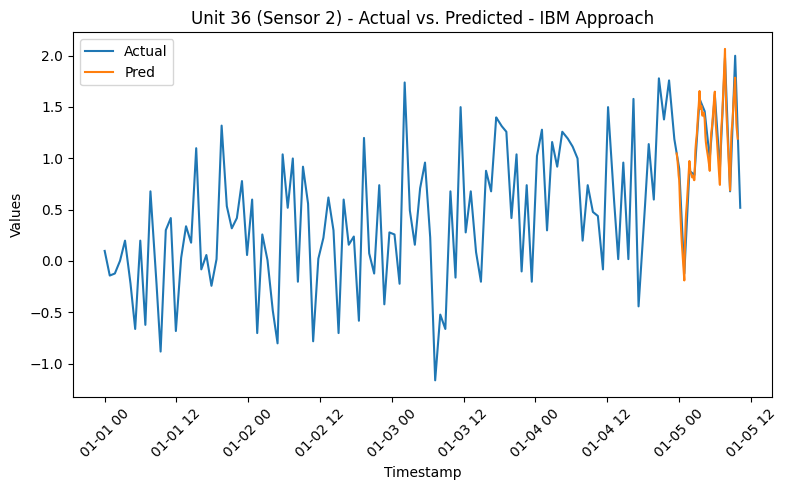

RMSE for Unit 36 - sensor_2: 0.29773200173210607
{'train': [0, 4897], 'valid': [4385, 5509], 'test': [4997, 6120]}
6121
Dataset for unit 37 is good


  0%|          | 0/129 [00:00<?, ?it/s]

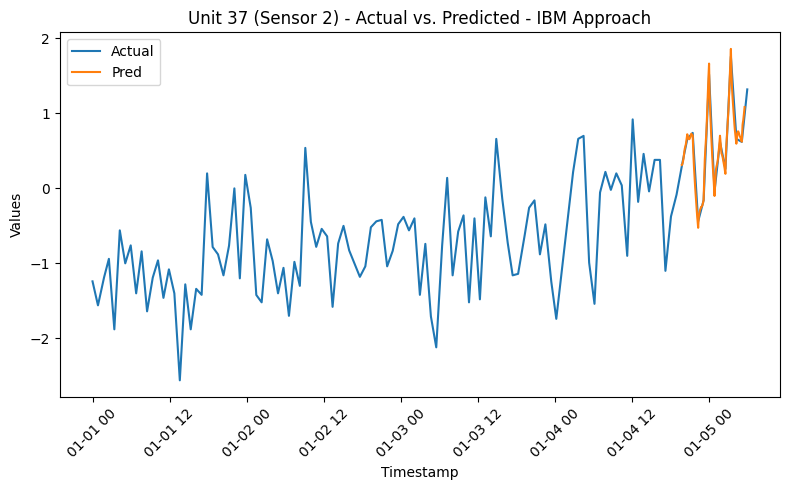

RMSE for Unit 37 - sensor_2: 0.35555495687488686
{'train': [0, 5060], 'valid': [4548, 5692], 'test': [5180, 6324]}
6325
Dataset for unit 38 is good


  0%|          | 0/132 [00:00<?, ?it/s]

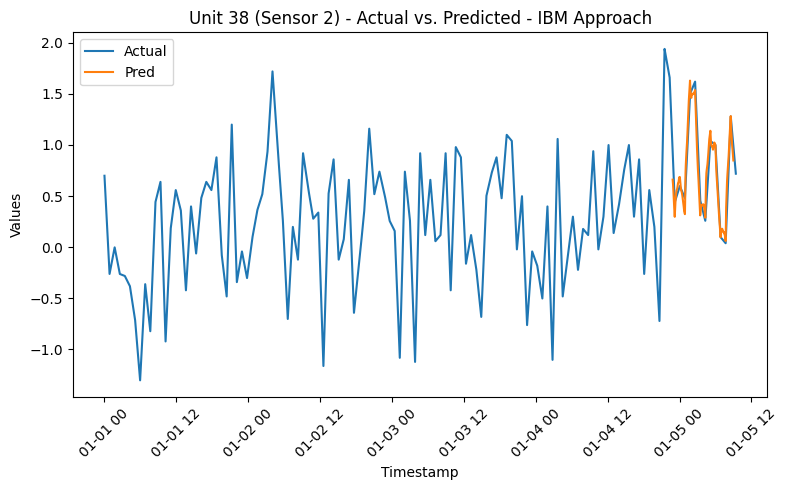

RMSE for Unit 38 - sensor_2: 0.2232477970395195
{'train': [0, 1470], 'valid': [958, 1653], 'test': [1141, 1836]}
1837
Dataset for unit 39 is good


  0%|          | 0/75 [00:00<?, ?it/s]

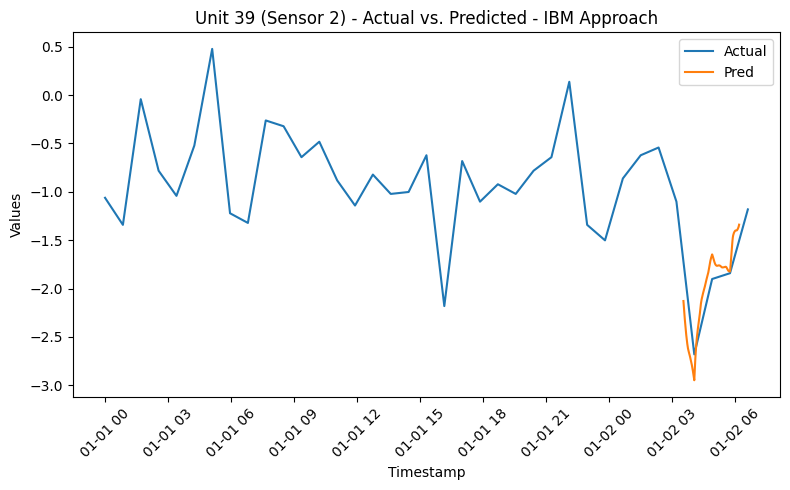

RMSE for Unit 39 - sensor_2: 0.20807000327826647
{'train': [0, 5386], 'valid': [4874, 6060], 'test': [5548, 6732]}
6733
Dataset for unit 40 is good


  0%|          | 0/137 [00:00<?, ?it/s]

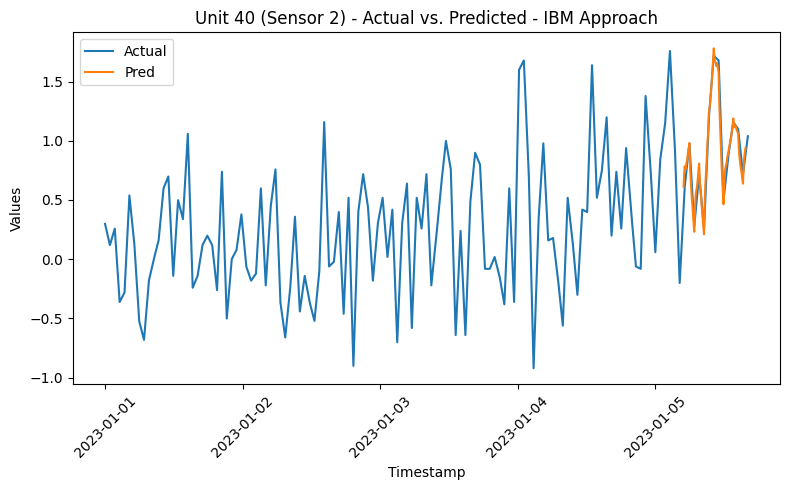

RMSE for Unit 40 - sensor_2: 0.18569384438120287
{'train': [0, 4978], 'valid': [4466, 5601], 'test': [5089, 6222]}
6223
Dataset for unit 41 is good


  0%|          | 0/130 [00:00<?, ?it/s]

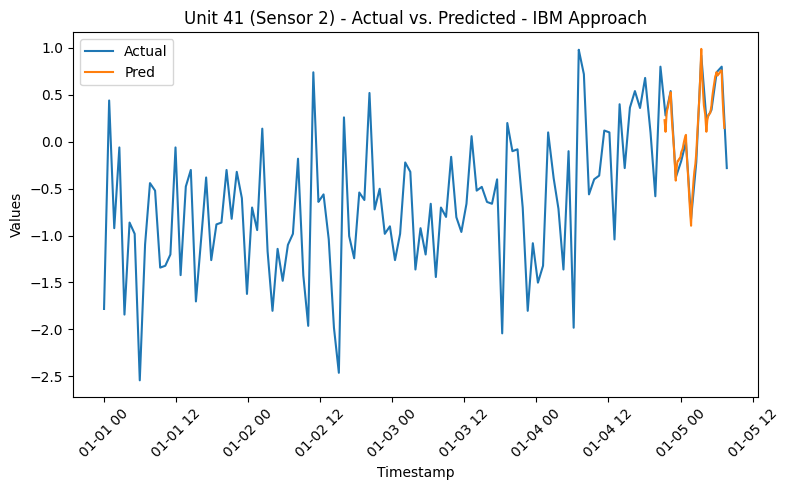

RMSE for Unit 41 - sensor_2: 0.2381408948639301
{'train': [0, 6325], 'valid': [5813, 7115], 'test': [6603, 7905]}
7906
Dataset for unit 42 is good


  0%|          | 0/151 [00:00<?, ?it/s]

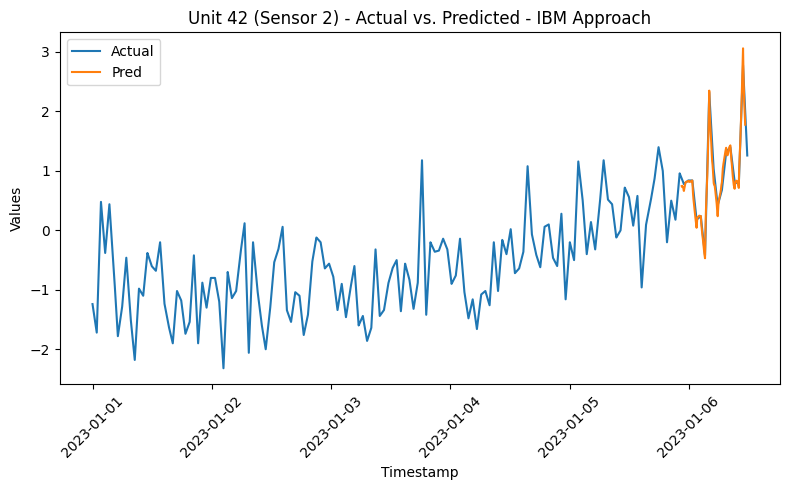

RMSE for Unit 42 - sensor_2: 0.410625523069122
{'train': [0, 6978], 'valid': [6466, 7850], 'test': [7338, 8721]}
8722
Dataset for unit 43 is good


  0%|          | 0/161 [00:00<?, ?it/s]

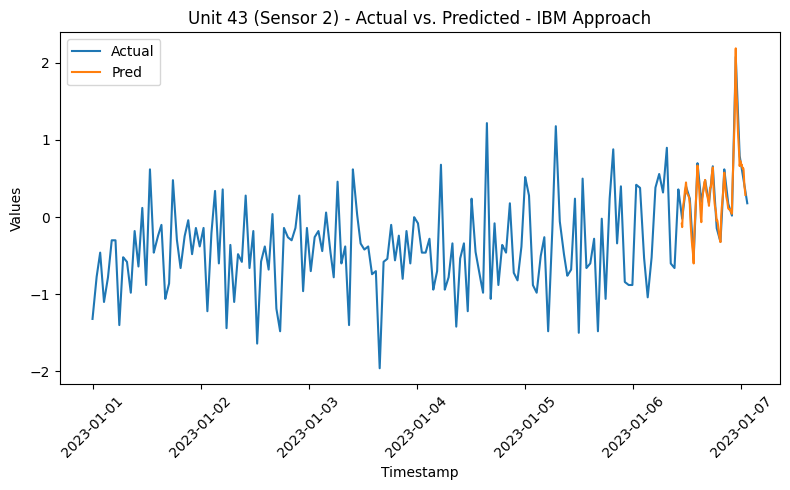

RMSE for Unit 43 - sensor_2: 0.31199671223247344
{'train': [0, 2163], 'valid': [1651, 2434], 'test': [1922, 2703]}
2704
Dataset for unit 44 is good


  0%|          | 0/86 [00:00<?, ?it/s]

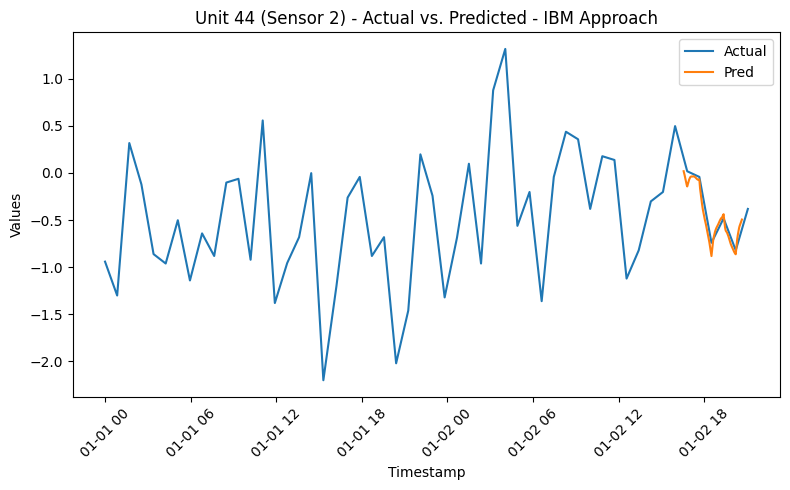

RMSE for Unit 44 - sensor_2: 0.13380194901177517
{'train': [0, 6162], 'valid': [5650, 6932], 'test': [6420, 7701]}
7702
Dataset for unit 45 is good


  0%|          | 0/149 [00:00<?, ?it/s]

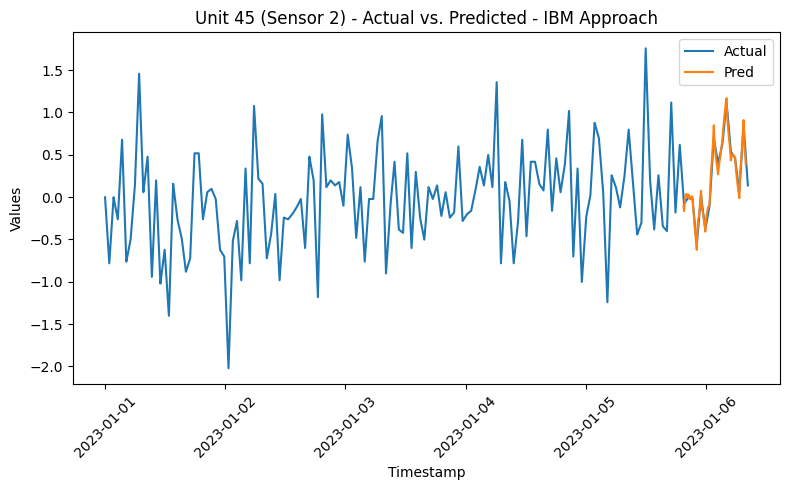

RMSE for Unit 45 - sensor_2: 0.1744758523133527
{'train': [0, 5917], 'valid': [5405, 6656], 'test': [6144, 7395]}
7396
Dataset for unit 46 is good


  0%|          | 0/145 [00:00<?, ?it/s]

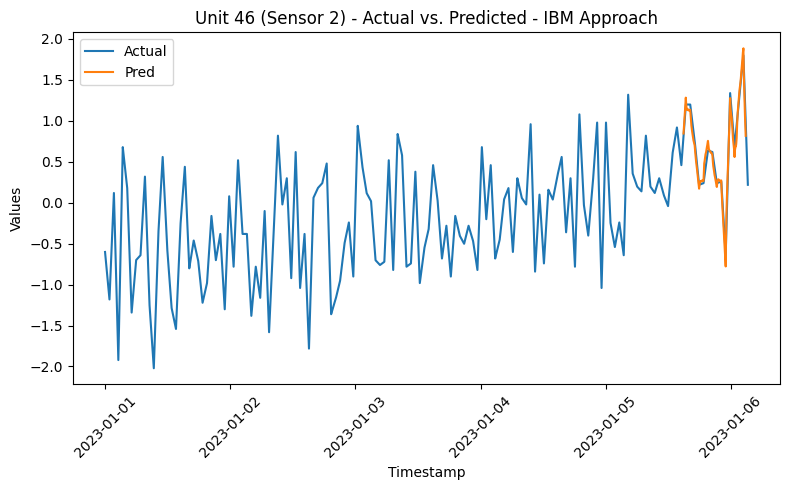

RMSE for Unit 46 - sensor_2: 0.30120824197270274
{'train': [0, 2938], 'valid': [2426, 3306], 'test': [2794, 3672]}
3673
Dataset for unit 47 is good


  0%|          | 0/98 [00:00<?, ?it/s]

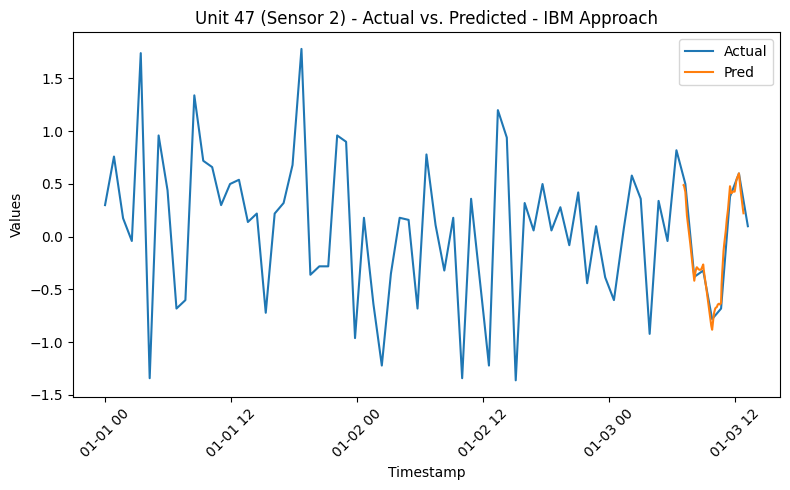

RMSE for Unit 47 - sensor_2: 0.19054720427849794
{'train': [0, 3142], 'valid': [2630, 3535], 'test': [3023, 3927]}
3928
Dataset for unit 48 is good


  0%|          | 0/102 [00:00<?, ?it/s]

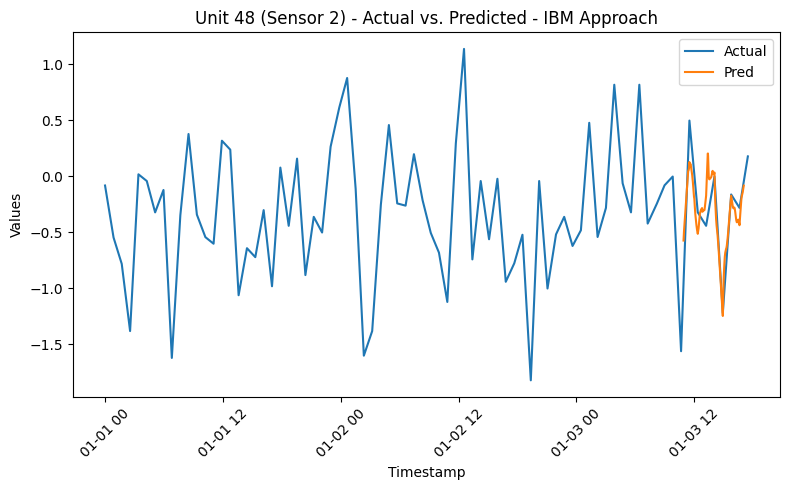

RMSE for Unit 48 - sensor_2: 0.29467865099548374
{'train': [0, 12322], 'valid': [11810, 13863], 'test': [13351, 15402]}
15403
Dataset for unit 49 is good


  0%|          | 0/245 [00:00<?, ?it/s]

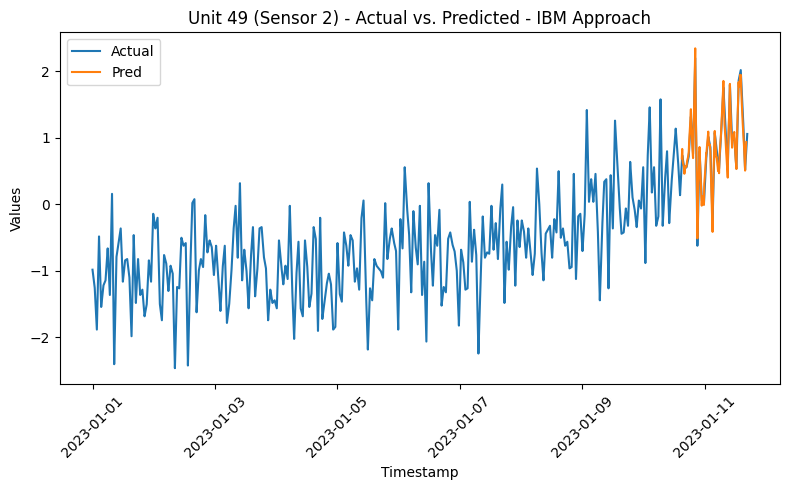

RMSE for Unit 49 - sensor_2: 0.3402016763573419
{'train': [0, 2979], 'valid': [2467, 3352], 'test': [2840, 3723]}
3724
Dataset for unit 50 is good


  0%|          | 0/99 [00:00<?, ?it/s]

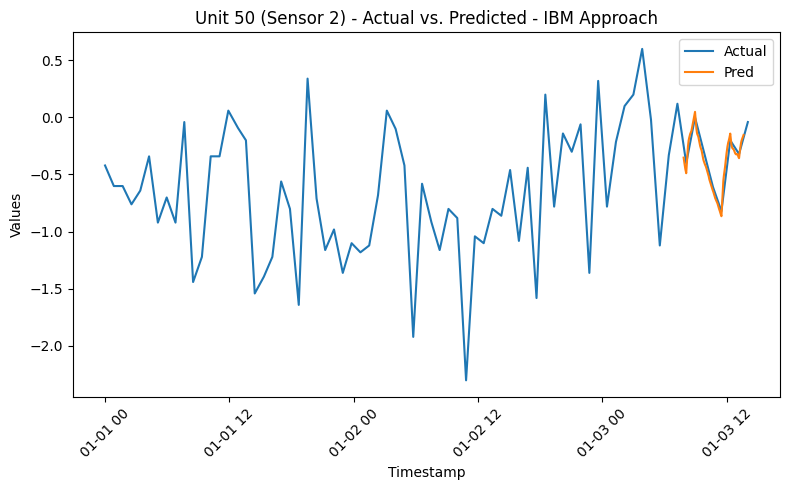

RMSE for Unit 50 - sensor_2: 0.11477883793988364
{'train': [0, 5835], 'valid': [5323, 6565], 'test': [6053, 7293]}
7294
Dataset for unit 51 is good


  0%|          | 0/144 [00:00<?, ?it/s]

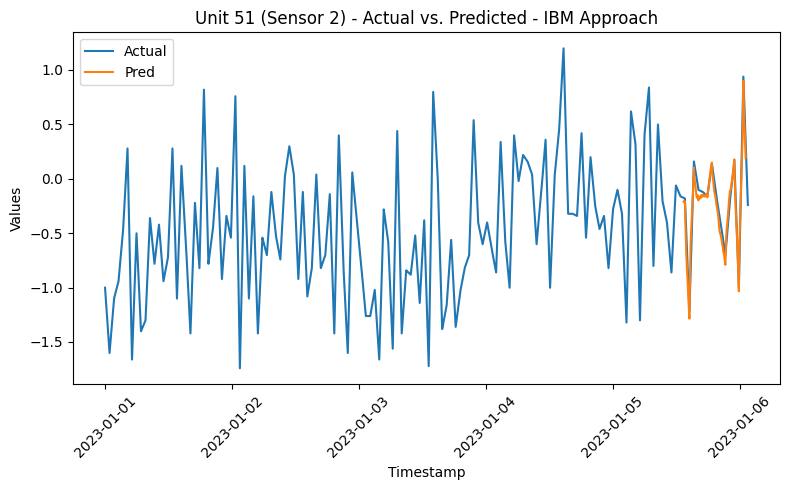

RMSE for Unit 51 - sensor_2: 0.3008945296918039
{'train': [0, 7671], 'valid': [7159, 8630], 'test': [8118, 9588]}
9589
Dataset for unit 52 is good


  0%|          | 0/172 [00:00<?, ?it/s]

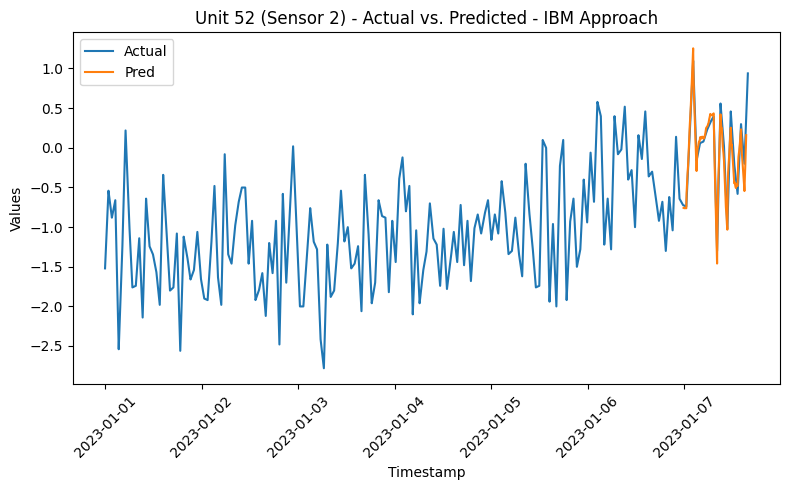

RMSE for Unit 52 - sensor_2: 0.3437170251957319
{'train': [0, 6651], 'valid': [6139, 7483], 'test': [6971, 8313]}
8314
Dataset for unit 53 is good


  0%|          | 0/156 [00:00<?, ?it/s]

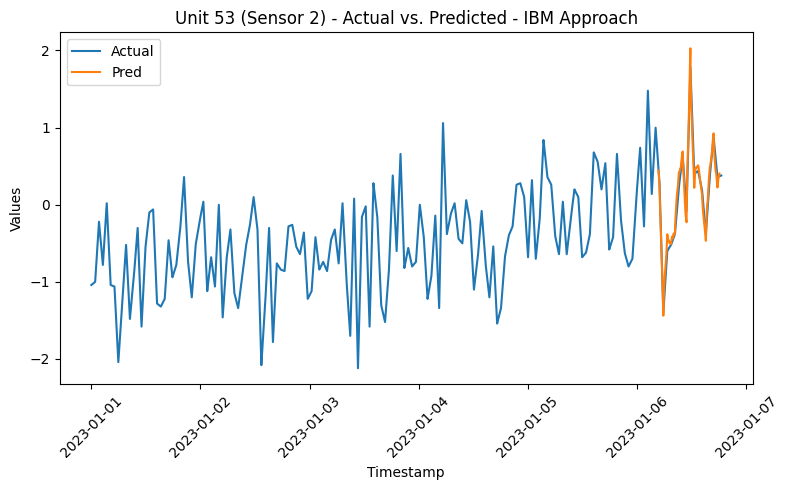

RMSE for Unit 53 - sensor_2: 0.3153996466085971
{'train': [0, 4897], 'valid': [4385, 5509], 'test': [4997, 6120]}
6121
Dataset for unit 54 is good


  0%|          | 0/129 [00:00<?, ?it/s]

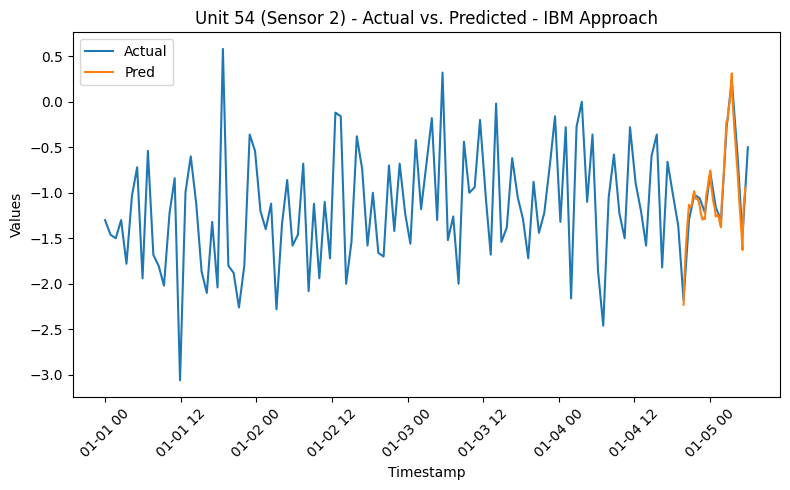

RMSE for Unit 54 - sensor_2: 0.2225842951511216
{'train': [0, 4570], 'valid': [4058, 5142], 'test': [4630, 5712]}
5713
Dataset for unit 55 is good


  0%|          | 0/124 [00:00<?, ?it/s]

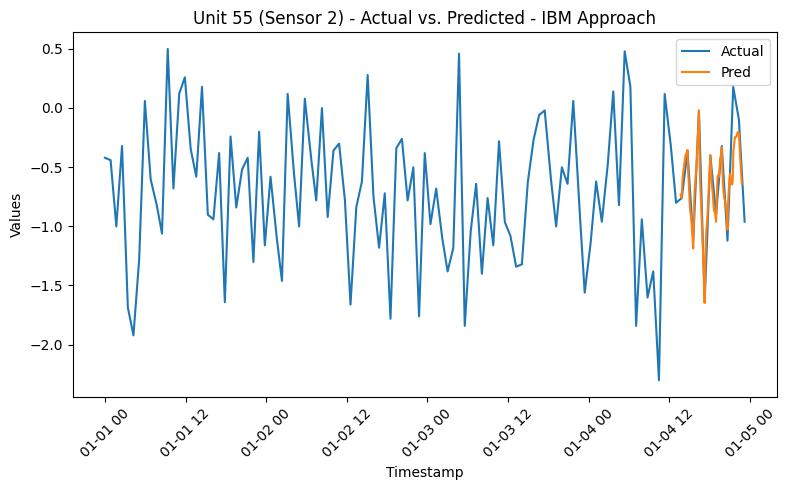

RMSE for Unit 55 - sensor_2: 0.3403128003953122
{'train': [0, 5509], 'valid': [4997, 6197], 'test': [5685, 6885]}
6886
Dataset for unit 56 is good


  0%|          | 0/139 [00:00<?, ?it/s]

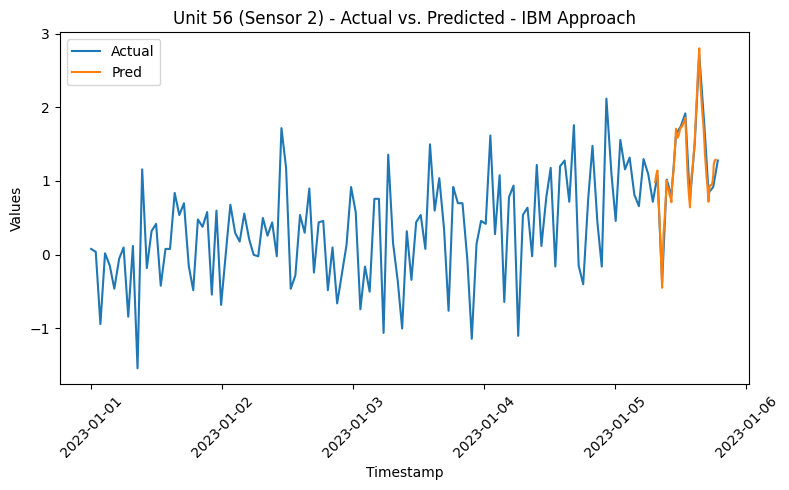

RMSE for Unit 56 - sensor_2: 0.31886036187105404
{'train': [0, 6488], 'valid': [5976, 7299], 'test': [6787, 8109]}
8110
Dataset for unit 57 is good


  0%|          | 0/154 [00:00<?, ?it/s]

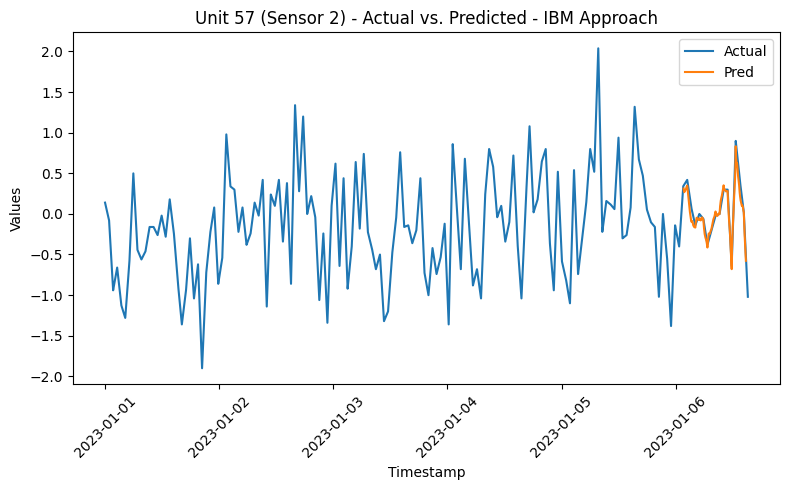

RMSE for Unit 57 - sensor_2: 0.2159438343998308
{'train': [0, 7141], 'valid': [6629, 8033], 'test': [7521, 8925]}
8926
Dataset for unit 58 is good


  0%|          | 0/164 [00:00<?, ?it/s]

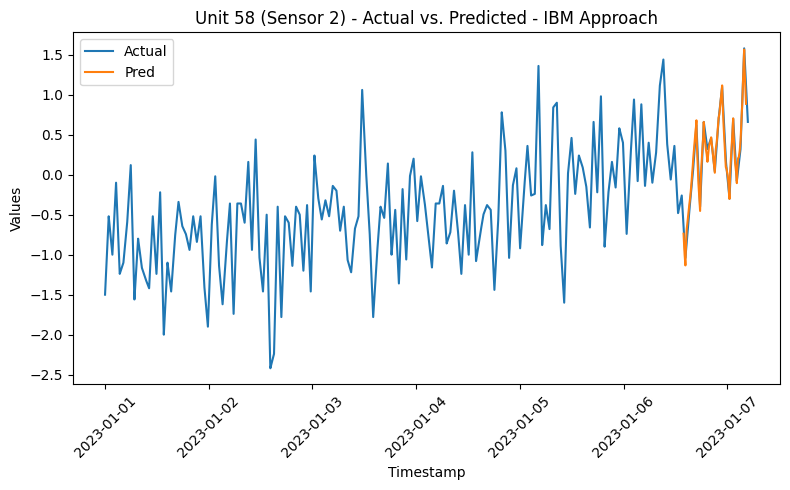

RMSE for Unit 58 - sensor_2: 0.2512023541995357
{'train': [0, 3795], 'valid': [3283, 4270], 'test': [3758, 4743]}
4744
Dataset for unit 59 is good


  0%|          | 0/112 [00:00<?, ?it/s]

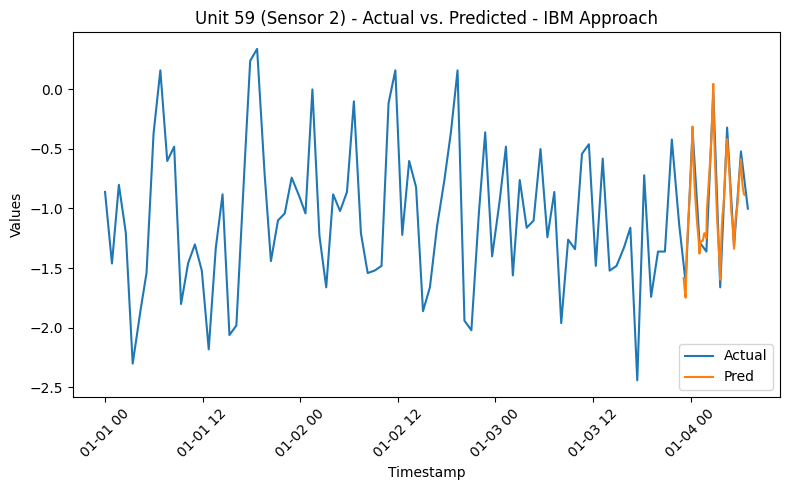

RMSE for Unit 59 - sensor_2: 0.3737693480105348
{'train': [0, 5958], 'valid': [5446, 6702], 'test': [6190, 7446]}
7447
Dataset for unit 60 is good


  0%|          | 0/146 [00:00<?, ?it/s]

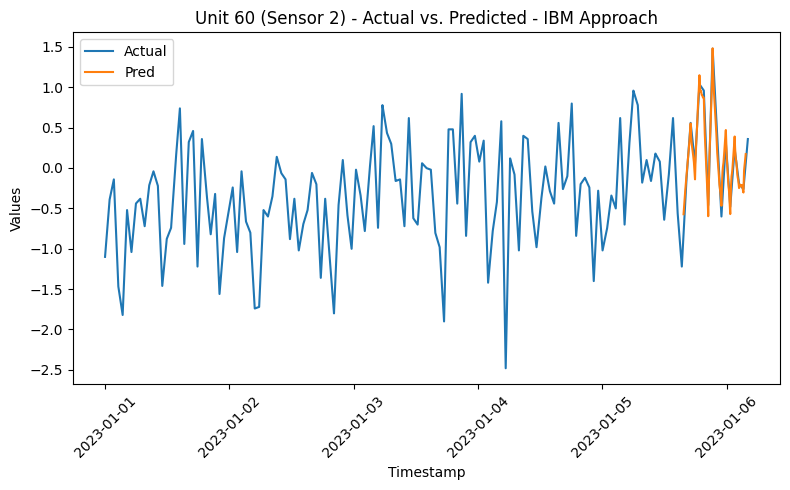

RMSE for Unit 60 - sensor_2: 0.33746785020337755
{'train': [0, 6447], 'valid': [5935, 7253], 'test': [6741, 8058]}
8059
Dataset for unit 61 is good


  0%|          | 0/153 [00:00<?, ?it/s]

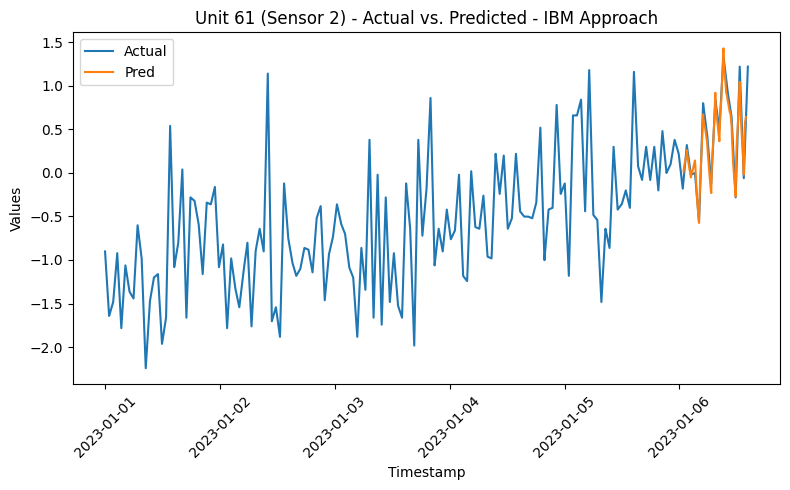

RMSE for Unit 61 - sensor_2: 0.29629930687006567
{'train': [0, 9426], 'valid': [8914, 10604], 'test': [10092, 11781]}
11782
Dataset for unit 62 is good


  0%|          | 0/200 [00:00<?, ?it/s]

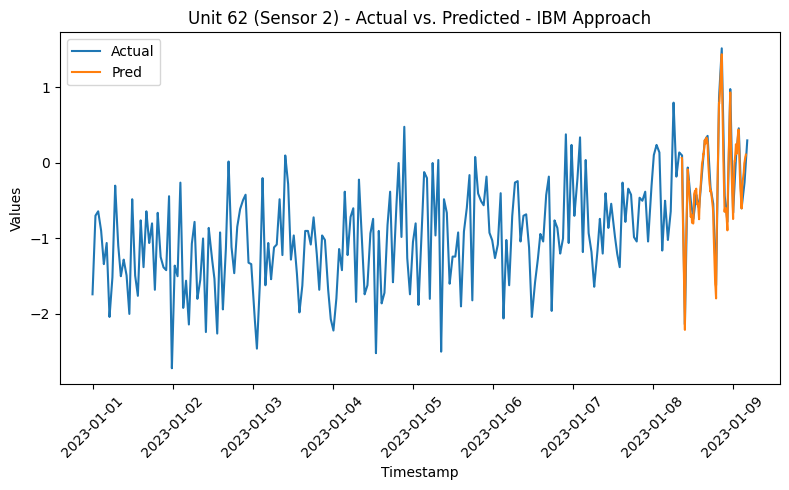

RMSE for Unit 62 - sensor_2: 0.3991986014060601
{'train': [0, 6284], 'valid': [5772, 7070], 'test': [6558, 7854]}
7855
Dataset for unit 63 is good


  0%|          | 0/151 [00:00<?, ?it/s]

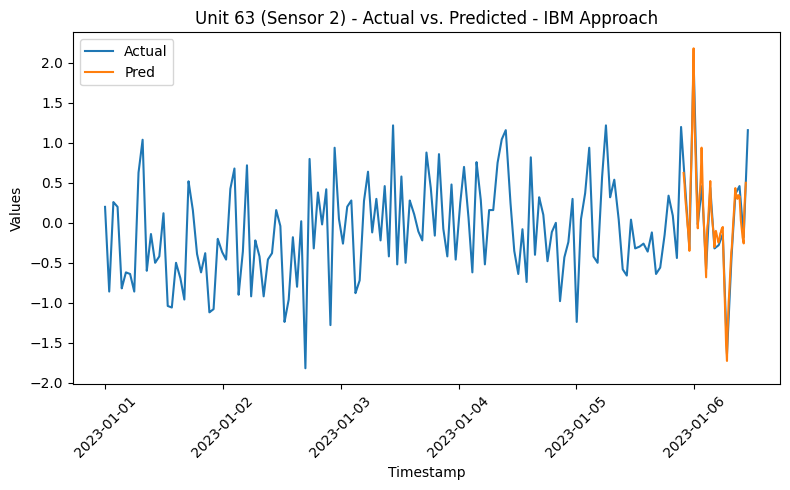

RMSE for Unit 63 - sensor_2: 0.43055962784067614
{'train': [0, 6814], 'valid': [6302, 7666], 'test': [7154, 8517]}
8518
Dataset for unit 64 is good


  0%|          | 0/159 [00:00<?, ?it/s]

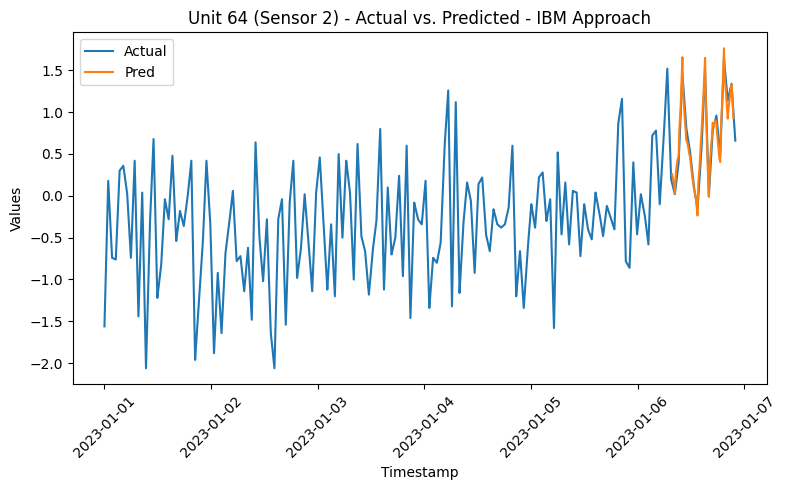

RMSE for Unit 64 - sensor_2: 0.2512745584678094
{'train': [0, 2857], 'valid': [2345, 3214], 'test': [2702, 3570]}
3571
Dataset for unit 65 is good


  0%|          | 0/97 [00:00<?, ?it/s]

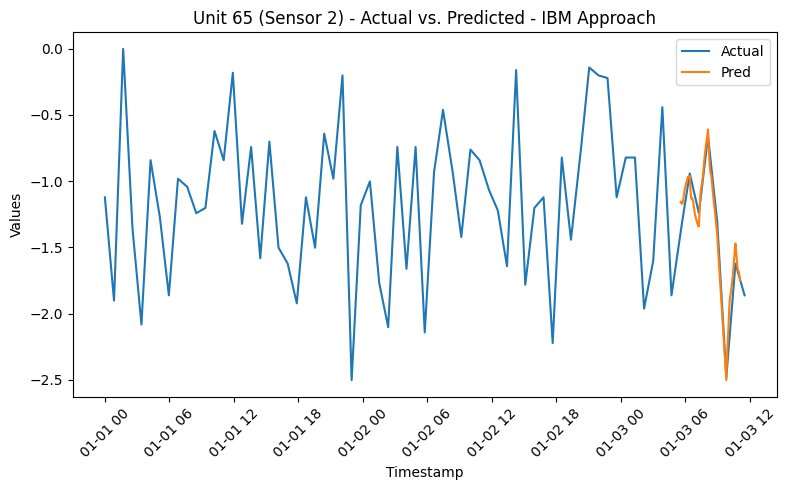

RMSE for Unit 65 - sensor_2: 0.23792092189623018
{'train': [0, 5958], 'valid': [5446, 6702], 'test': [6190, 7446]}
7447
Dataset for unit 66 is good


  0%|          | 0/146 [00:00<?, ?it/s]

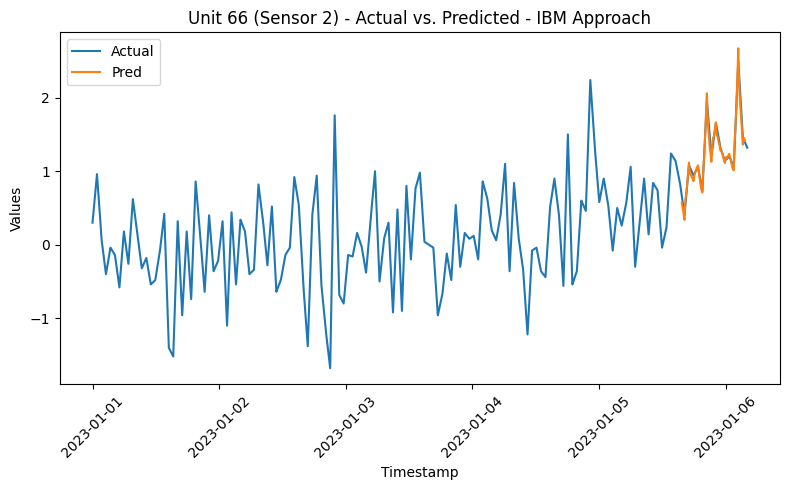

RMSE for Unit 66 - sensor_2: 0.25630752343790614
{'train': [0, 2857], 'valid': [2345, 3214], 'test': [2702, 3570]}
3571
Dataset for unit 67 is good


  0%|          | 0/97 [00:00<?, ?it/s]

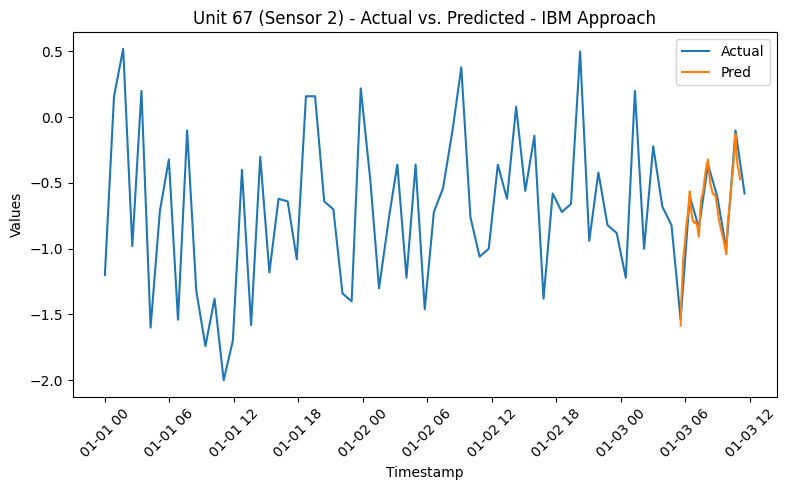

RMSE for Unit 67 - sensor_2: 0.19831768742399764
{'train': [0, 7590], 'valid': [7078, 8538], 'test': [8026, 9486]}
9487
Dataset for unit 68 is good


  0%|          | 0/171 [00:00<?, ?it/s]

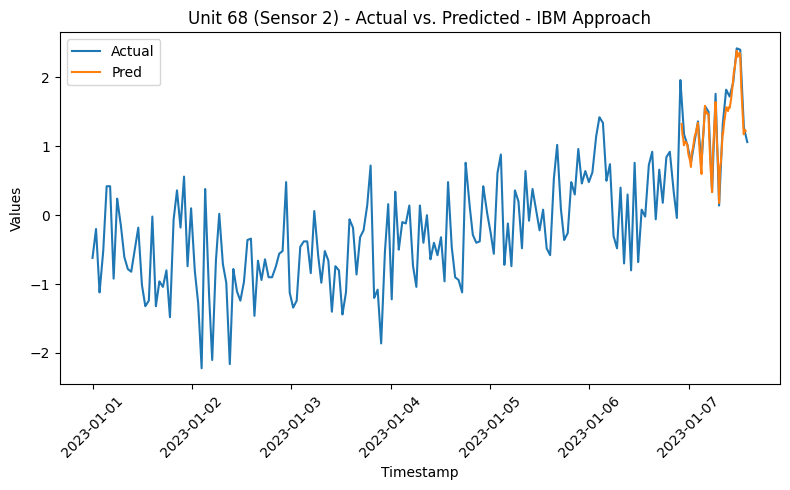

RMSE for Unit 68 - sensor_2: 0.28491735889590686
{'train': [0, 2163], 'valid': [1651, 2434], 'test': [1922, 2703]}
2704
Dataset for unit 69 is good


  0%|          | 0/86 [00:00<?, ?it/s]

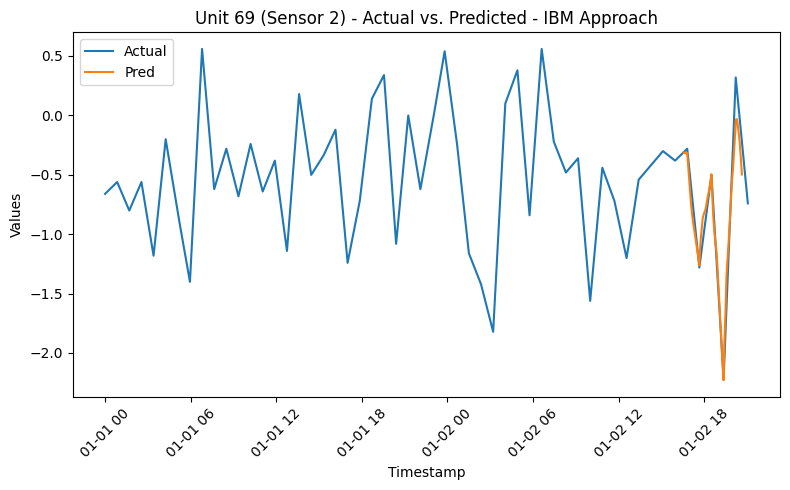

RMSE for Unit 69 - sensor_2: 0.5669768688830185
{'train': [0, 6162], 'valid': [5650, 6932], 'test': [6420, 7701]}
7702
Dataset for unit 70 is good


  0%|          | 0/149 [00:00<?, ?it/s]

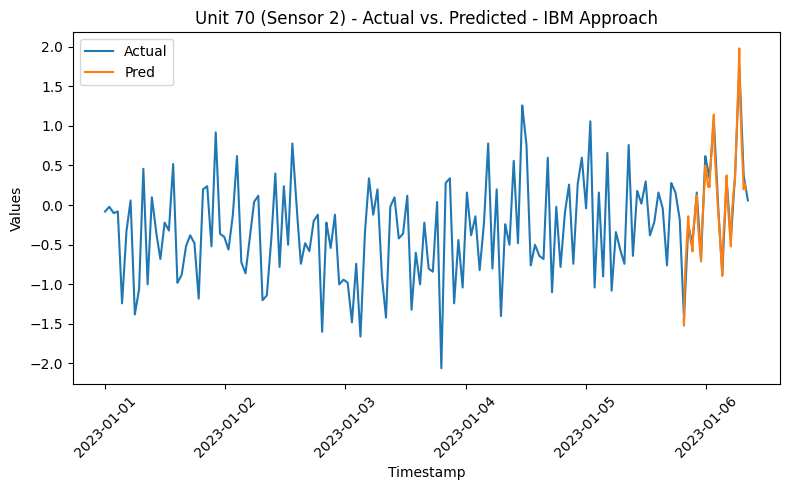

RMSE for Unit 70 - sensor_2: 0.352163552024646
{'train': [0, 2734], 'valid': [2222, 3076], 'test': [2564, 3417]}
3418
Dataset for unit 71 is good


  0%|          | 0/95 [00:00<?, ?it/s]

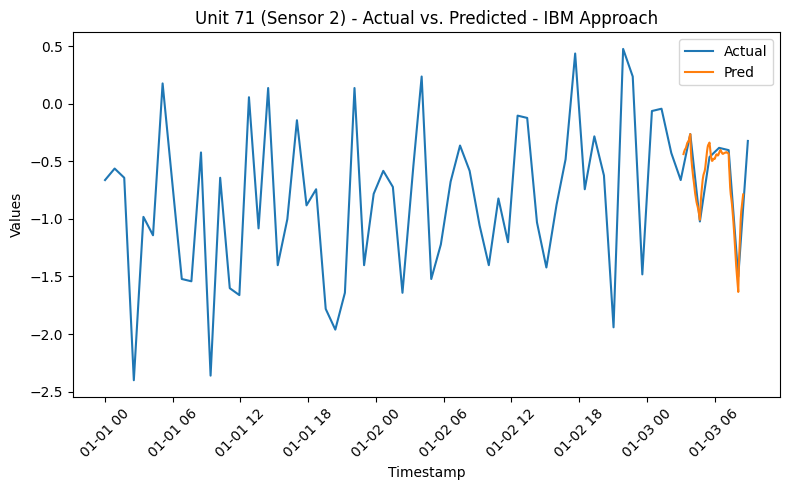

RMSE for Unit 71 - sensor_2: 0.2394866966894745
{'train': [0, 5305], 'valid': [4793, 5968], 'test': [5456, 6630]}
6631
Dataset for unit 72 is good


  0%|          | 0/135 [00:00<?, ?it/s]

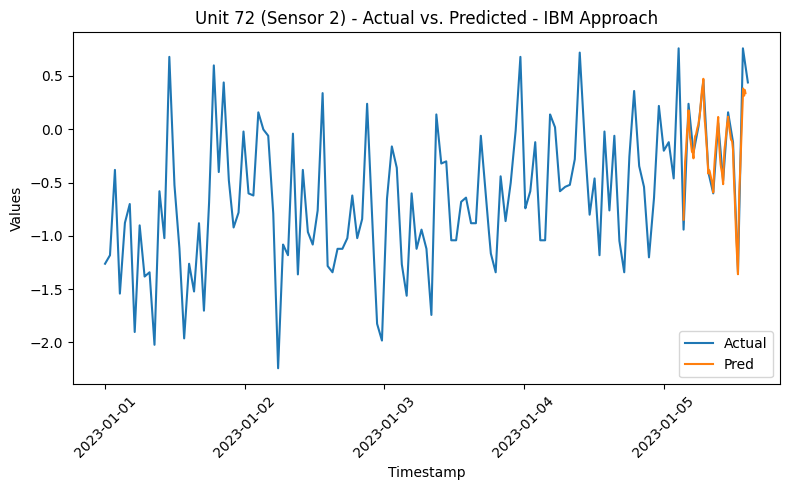

RMSE for Unit 72 - sensor_2: 0.31879779026599936
{'train': [0, 4530], 'valid': [4018, 5096], 'test': [4584, 5661]}
5662
Dataset for unit 73 is good


  0%|          | 0/123 [00:00<?, ?it/s]

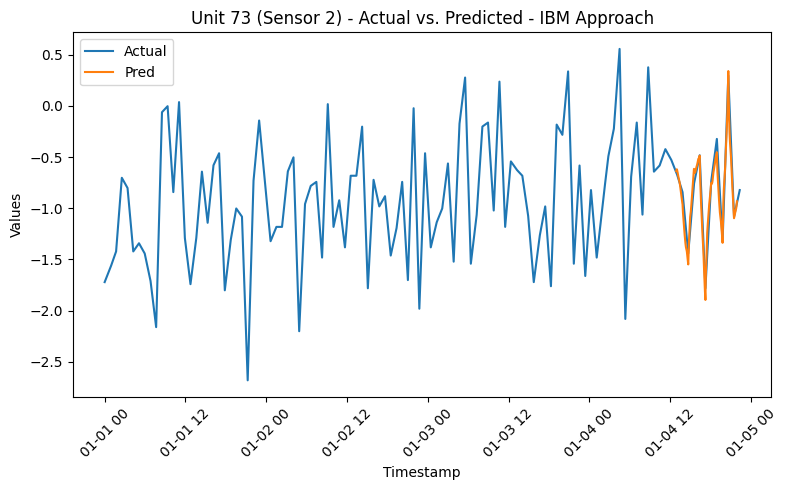

RMSE for Unit 73 - sensor_2: 0.3182634695078025
{'train': [0, 5550], 'valid': [5038, 6243], 'test': [5731, 6936]}
6937
Dataset for unit 74 is good


  0%|          | 0/139 [00:00<?, ?it/s]

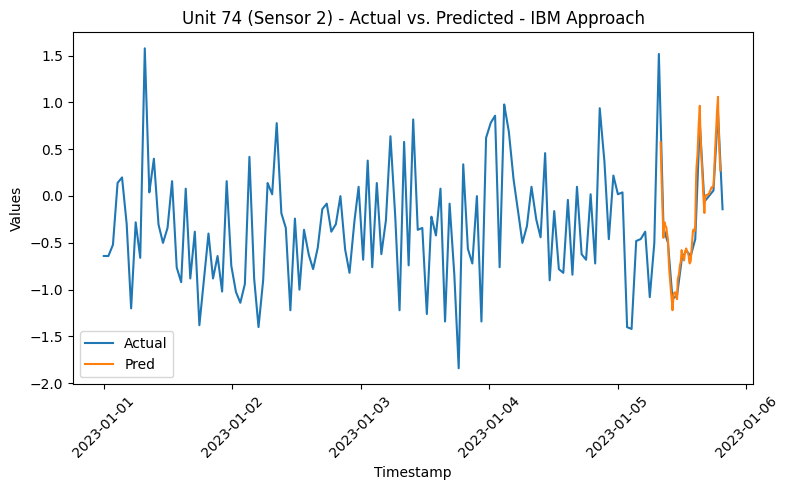

RMSE for Unit 74 - sensor_2: 0.21967124178973765
{'train': [0, 3550], 'valid': [3038, 3994], 'test': [3482, 4437]}
4438
Dataset for unit 75 is good


  0%|          | 0/108 [00:00<?, ?it/s]

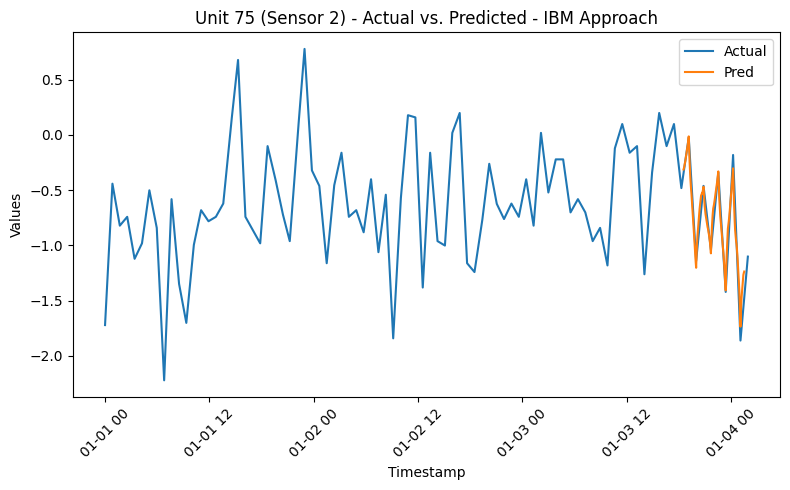

RMSE for Unit 75 - sensor_2: 0.3361685875201656
{'train': [0, 8324], 'valid': [7812, 9364], 'test': [8852, 10404]}
10405
Dataset for unit 76 is good


  0%|          | 0/183 [00:00<?, ?it/s]

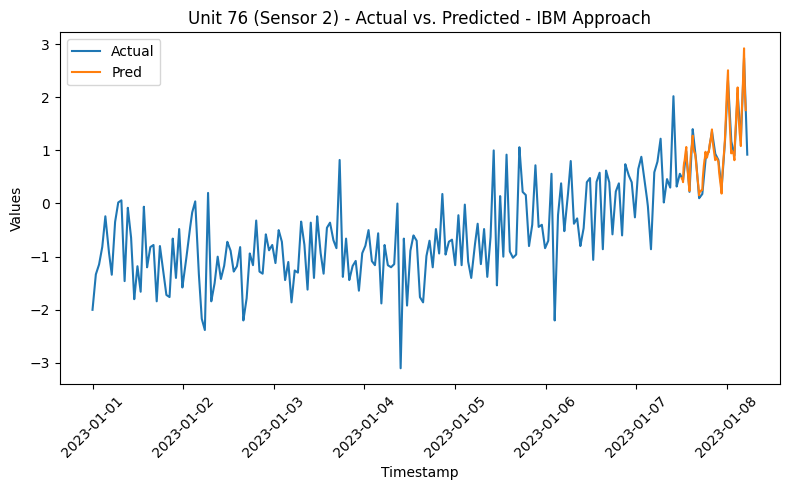

RMSE for Unit 76 - sensor_2: 0.3103575784694967
{'train': [0, 6570], 'valid': [6058, 7391], 'test': [6879, 8211]}
8212
Dataset for unit 77 is good


  0%|          | 0/155 [00:00<?, ?it/s]

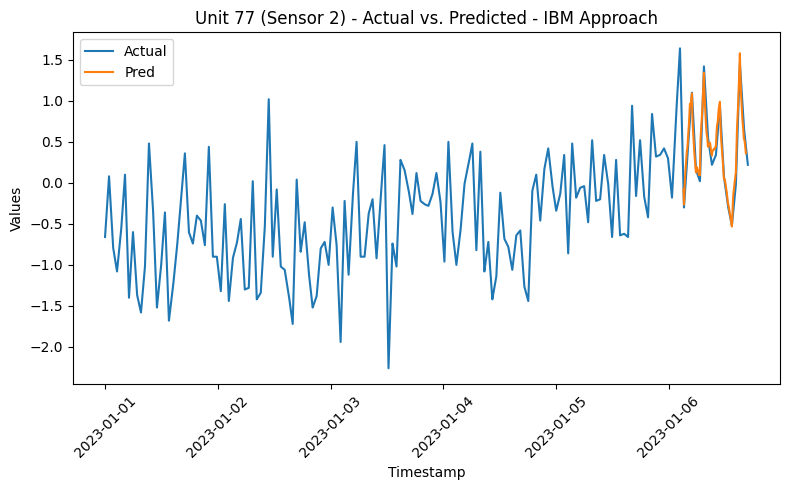

RMSE for Unit 77 - sensor_2: 0.23247773554003126
{'train': [0, 2898], 'valid': [2386, 3260], 'test': [2748, 3621]}
3622
Dataset for unit 78 is good


  0%|          | 0/98 [00:00<?, ?it/s]

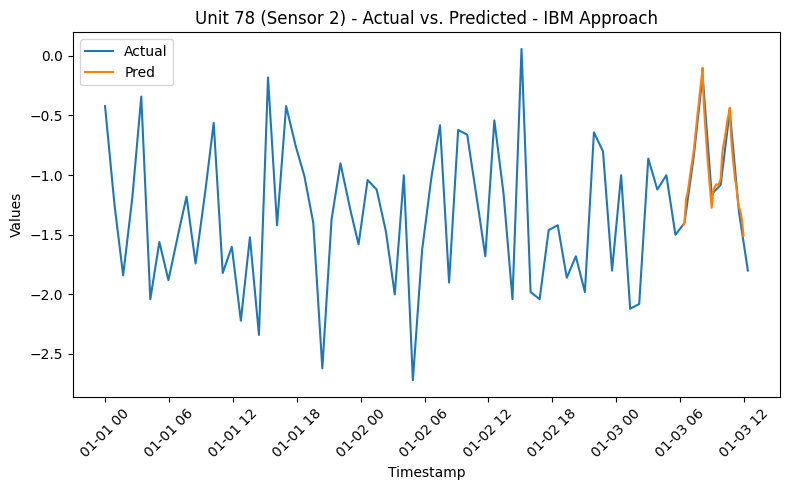

RMSE for Unit 78 - sensor_2: 0.24286678465292186
{'train': [0, 4081], 'valid': [3569, 4591], 'test': [4079, 5100]}
5101
Dataset for unit 79 is good


  0%|          | 0/116 [00:00<?, ?it/s]

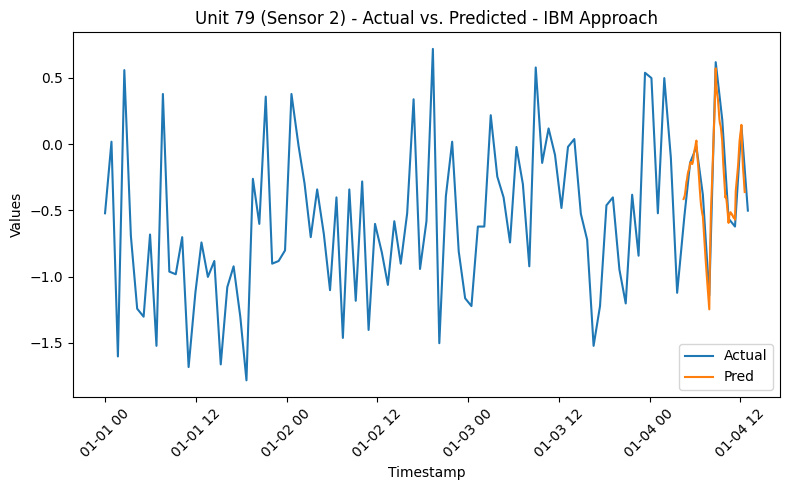

RMSE for Unit 79 - sensor_2: 0.25462160244313
{'train': [0, 5386], 'valid': [4874, 6060], 'test': [5548, 6732]}
6733
Dataset for unit 80 is good


  0%|          | 0/137 [00:00<?, ?it/s]

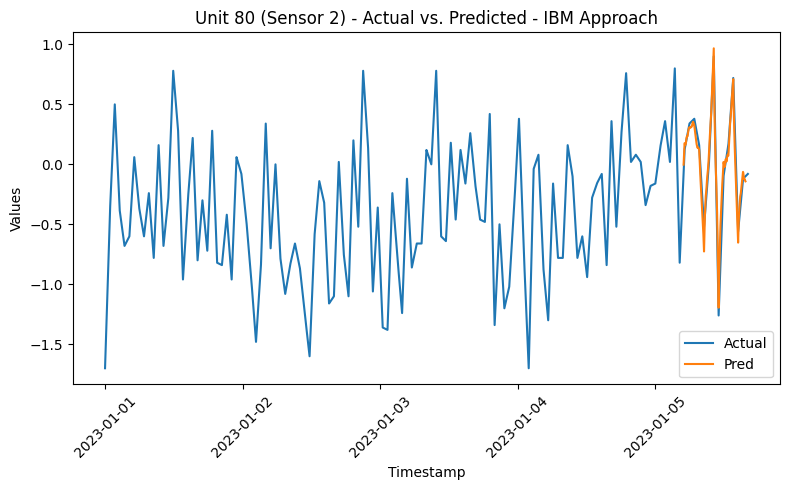

RMSE for Unit 80 - sensor_2: 0.3231292721965857
{'train': [0, 8650], 'valid': [8138, 9732], 'test': [9220, 10812]}
10813
Dataset for unit 81 is good


  0%|          | 0/188 [00:00<?, ?it/s]

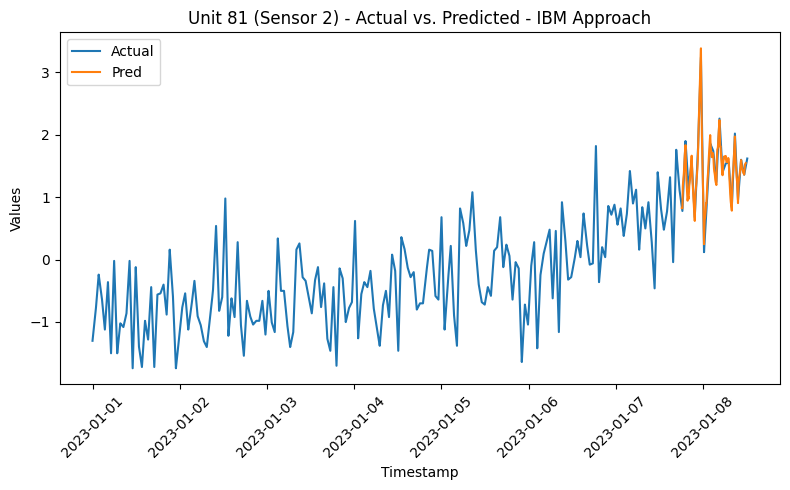

RMSE for Unit 81 - sensor_2: 0.38318512354788814
{'train': [0, 6570], 'valid': [6058, 7391], 'test': [6879, 8211]}
8212
Dataset for unit 82 is good


  0%|          | 0/155 [00:00<?, ?it/s]

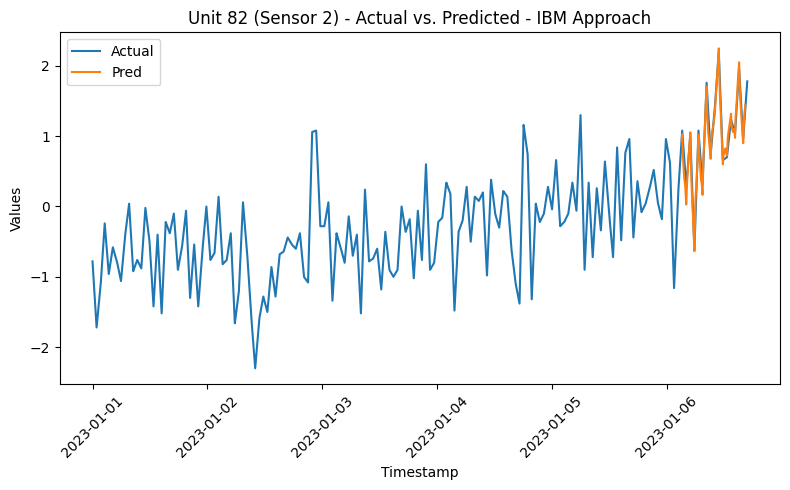

RMSE for Unit 82 - sensor_2: 0.36396458541803
{'train': [0, 2938], 'valid': [2426, 3306], 'test': [2794, 3672]}
3673
Dataset for unit 83 is good


  0%|          | 0/98 [00:00<?, ?it/s]

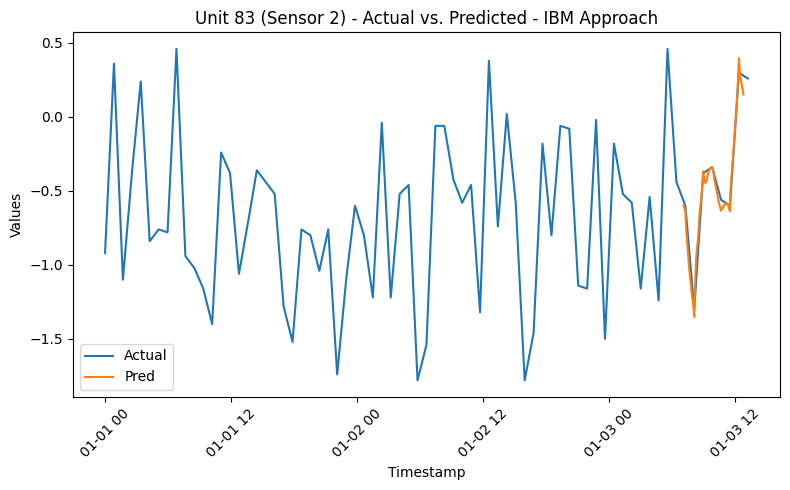

RMSE for Unit 83 - sensor_2: 0.2069803638375876
{'train': [0, 6978], 'valid': [6466, 7850], 'test': [7338, 8721]}
8722
Dataset for unit 84 is good


  0%|          | 0/161 [00:00<?, ?it/s]

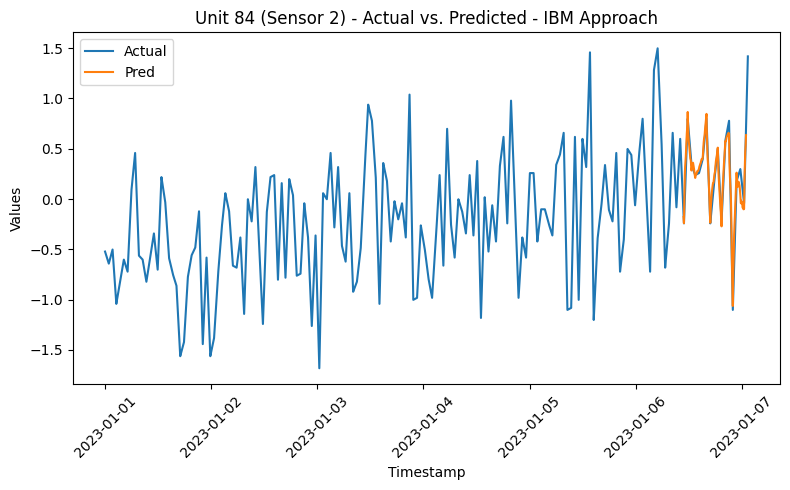

RMSE for Unit 84 - sensor_2: 0.2956764541976761
{'train': [0, 1347], 'valid': [835, 1516], 'test': [1004, 1683]}
1684
Dataset for unit 85 is good


  0%|          | 0/73 [00:00<?, ?it/s]

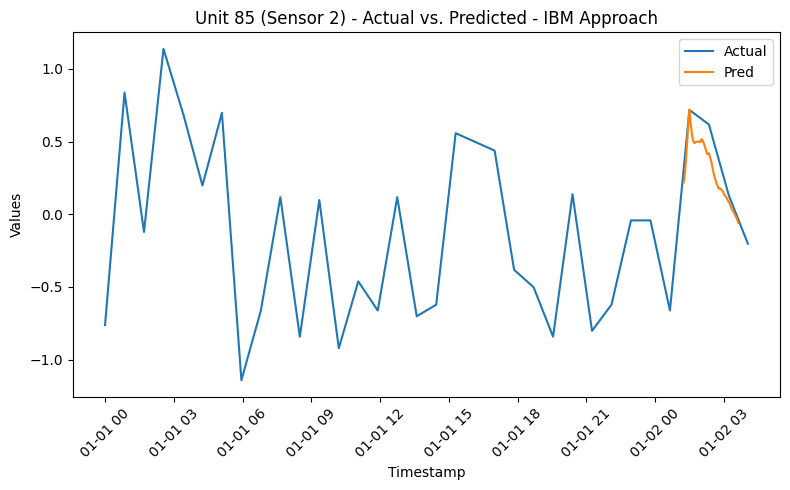

RMSE for Unit 85 - sensor_2: 0.1310957988549473
{'train': [0, 4448], 'valid': [3936, 5004], 'test': [4492, 5559]}
5560
Dataset for unit 86 is good


  0%|          | 0/122 [00:00<?, ?it/s]

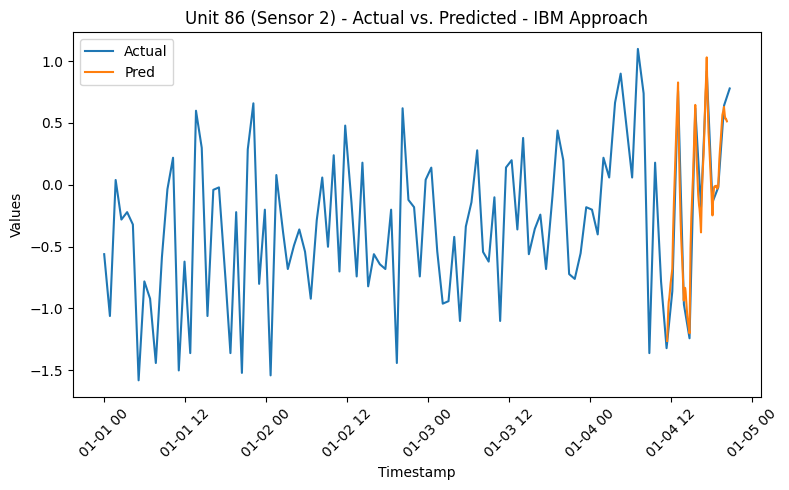

RMSE for Unit 86 - sensor_2: 0.3671708057377523
{'train': [0, 2245], 'valid': [1733, 2525], 'test': [2013, 2805]}
2806
Dataset for unit 87 is good


  0%|          | 0/88 [00:00<?, ?it/s]

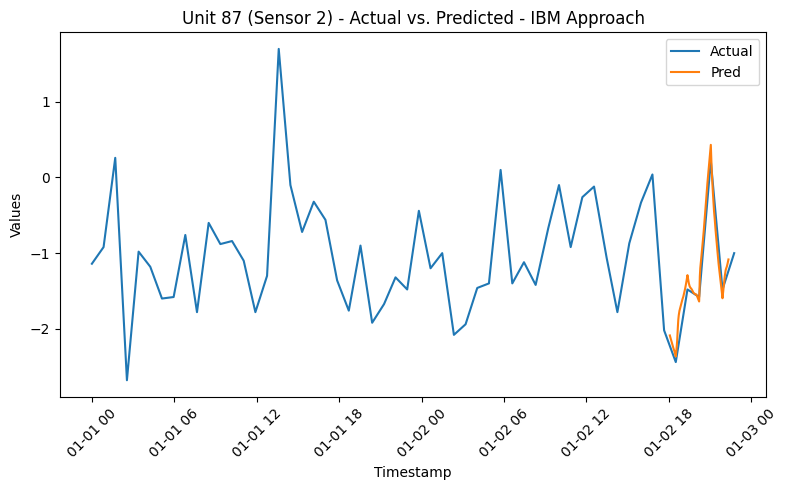

RMSE for Unit 87 - sensor_2: 0.40850869303465576
{'train': [0, 2734], 'valid': [2222, 3076], 'test': [2564, 3417]}
3418
Dataset for unit 88 is good


  0%|          | 0/95 [00:00<?, ?it/s]

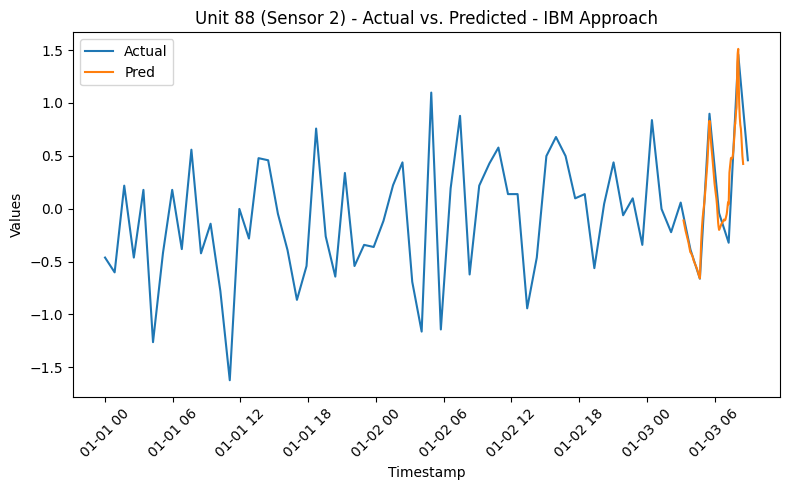

RMSE for Unit 88 - sensor_2: 0.358640761957487
{'train': [0, 7182], 'valid': [6670, 8079], 'test': [7567, 8976]}
8977
Dataset for unit 89 is good


  0%|          | 0/165 [00:00<?, ?it/s]

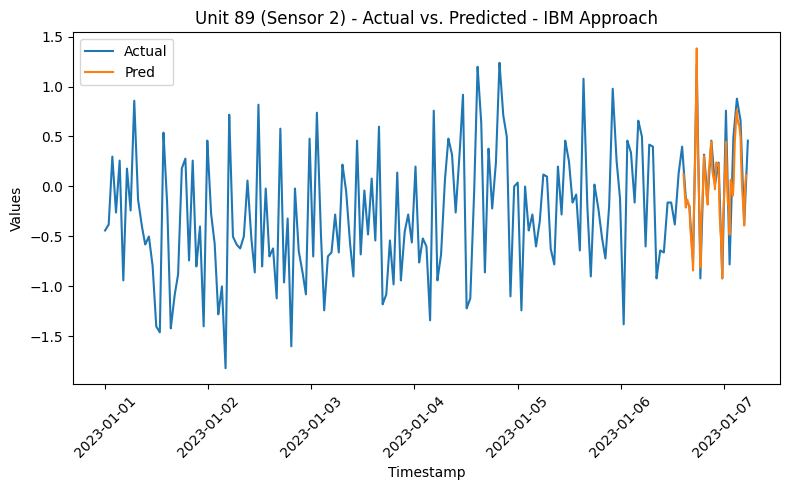

RMSE for Unit 89 - sensor_2: 0.4004469570184777
{'train': [0, 5917], 'valid': [5405, 6656], 'test': [6144, 7395]}
7396
Dataset for unit 90 is good


  0%|          | 0/145 [00:00<?, ?it/s]

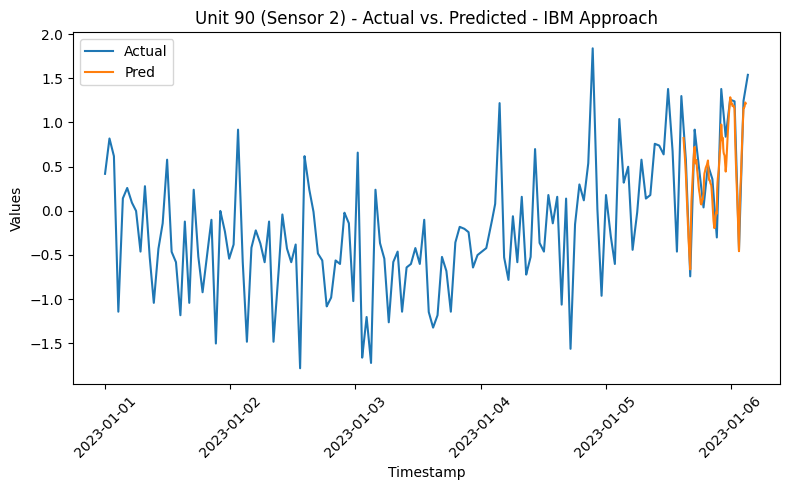

RMSE for Unit 90 - sensor_2: 0.35342188826240234
{'train': [0, 9507], 'valid': [8995, 10696], 'test': [10184, 11883]}
11884
Dataset for unit 91 is good


  0%|          | 0/201 [00:00<?, ?it/s]

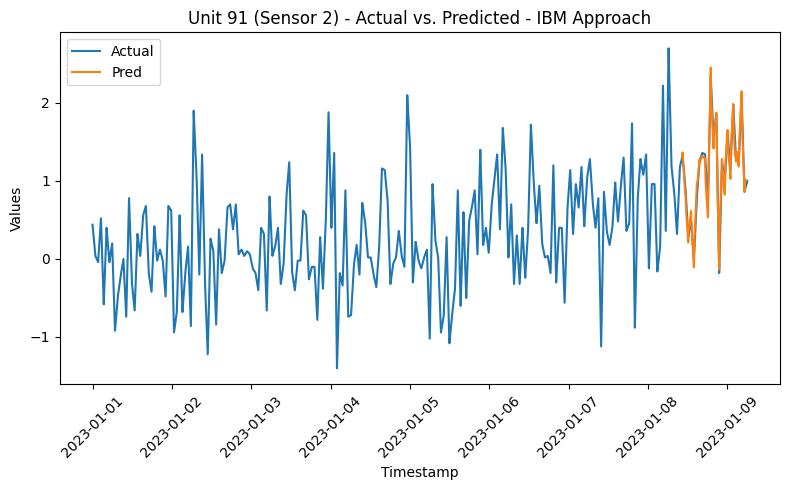

RMSE for Unit 91 - sensor_2: 0.30504383553488984
{'train': [0, 6080], 'valid': [5568, 6840], 'test': [6328, 7599]}
7600
Dataset for unit 92 is good


  0%|          | 0/147 [00:00<?, ?it/s]

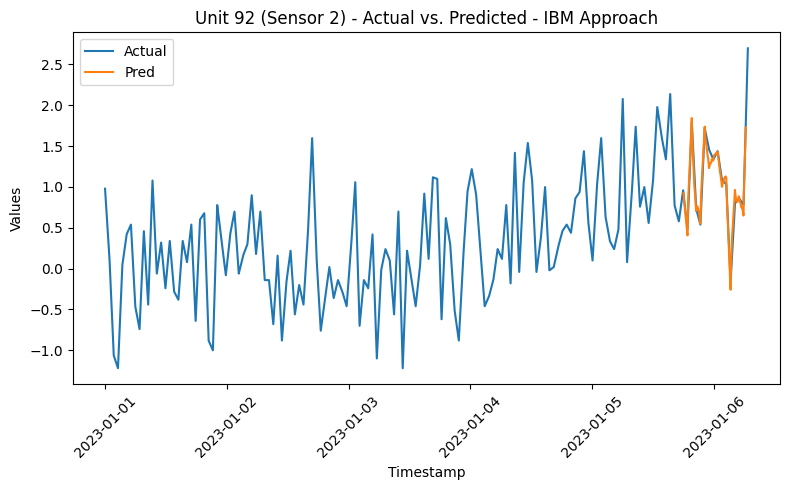

RMSE for Unit 92 - sensor_2: 0.3252354491695239
{'train': [0, 9915], 'valid': [9403, 11155], 'test': [10643, 12393]}
12394
Dataset for unit 93 is good


  0%|          | 0/207 [00:00<?, ?it/s]

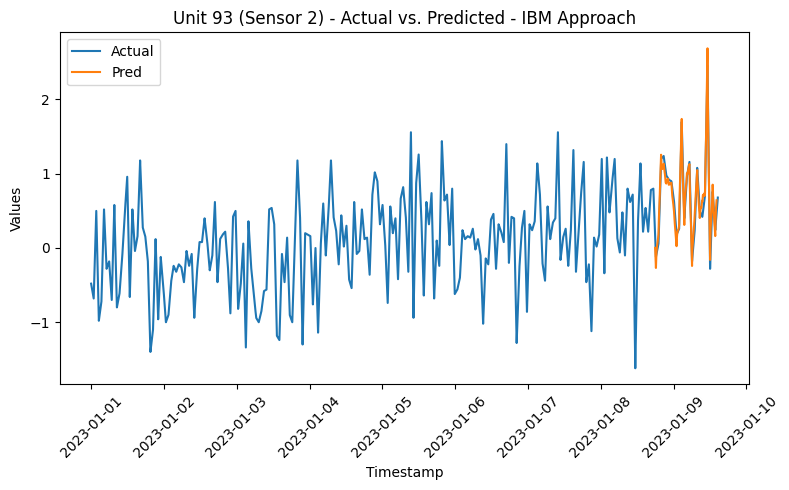

RMSE for Unit 93 - sensor_2: 0.3413582207385779
{'train': [0, 5386], 'valid': [4874, 6060], 'test': [5548, 6732]}
6733
Dataset for unit 94 is good


  0%|          | 0/137 [00:00<?, ?it/s]

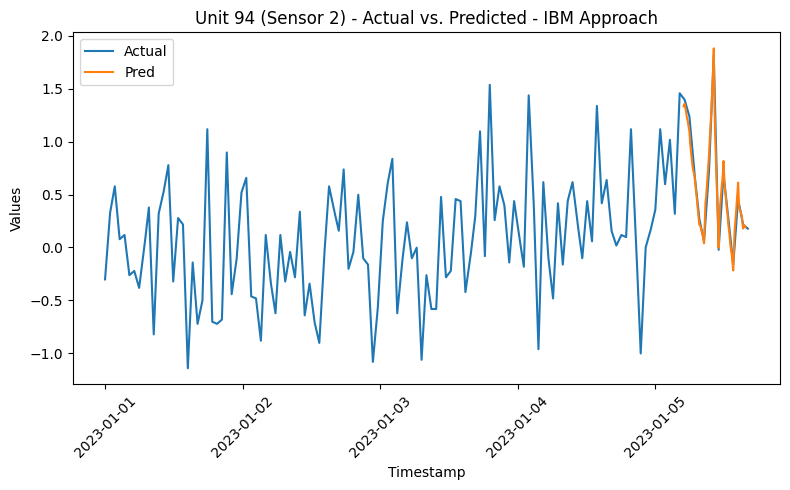

RMSE for Unit 94 - sensor_2: 0.24406779384561372
{'train': [0, 3591], 'valid': [3079, 4040], 'test': [3528, 4488]}
4489
Dataset for unit 95 is good


  0%|          | 0/109 [00:00<?, ?it/s]

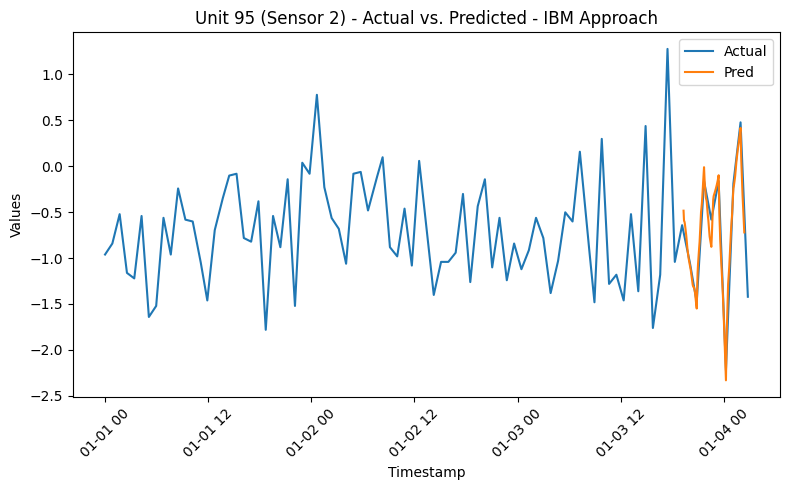

RMSE for Unit 95 - sensor_2: 0.4747478398888608
{'train': [0, 3918], 'valid': [3406, 4407], 'test': [3895, 4896]}
4897
Dataset for unit 96 is good


  0%|          | 0/114 [00:00<?, ?it/s]

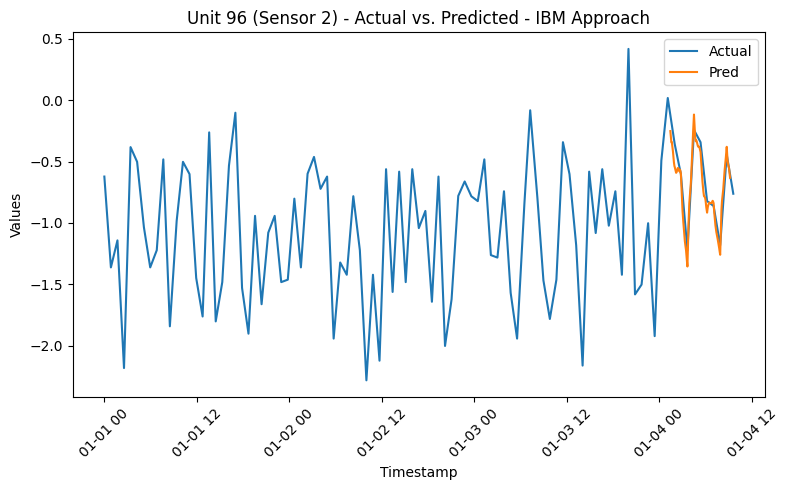

RMSE for Unit 96 - sensor_2: 0.17997460468430765
{'train': [0, 5427], 'valid': [4915, 6106], 'test': [5594, 6783]}
6784
Dataset for unit 97 is good


  0%|          | 0/137 [00:00<?, ?it/s]

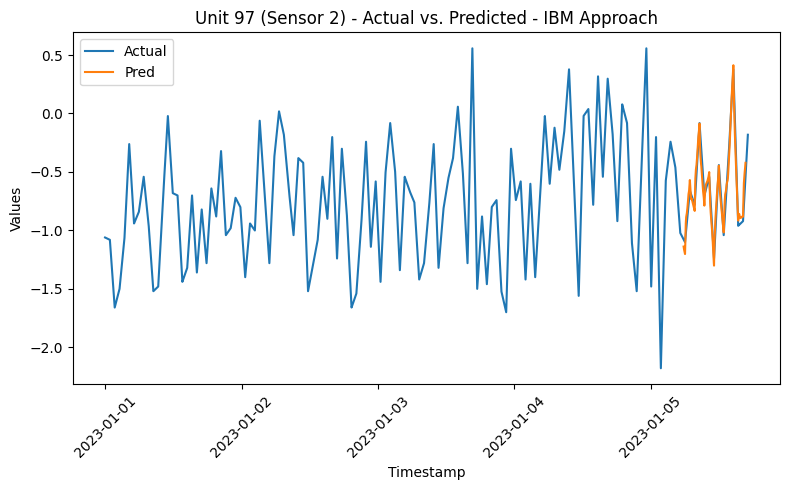

RMSE for Unit 97 - sensor_2: 0.2415056332682464
{'train': [0, 4897], 'valid': [4385, 5509], 'test': [4997, 6120]}
6121
Dataset for unit 98 is good


  0%|          | 0/129 [00:00<?, ?it/s]

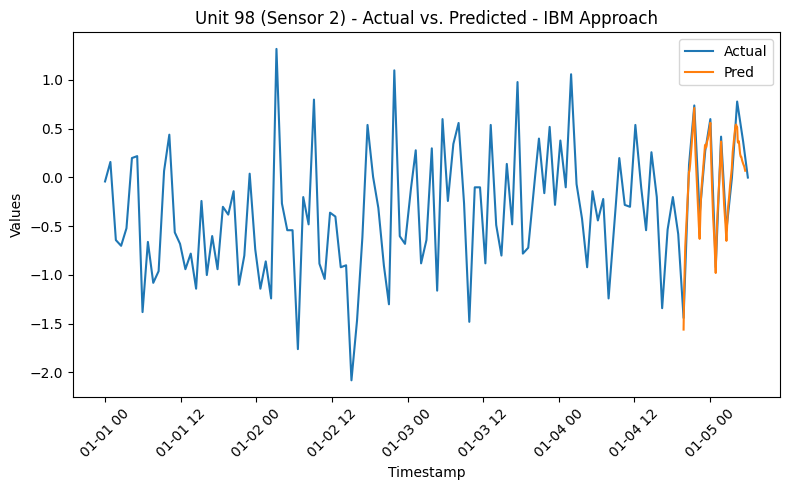

RMSE for Unit 98 - sensor_2: 0.3313729294623157
{'train': [0, 3918], 'valid': [3406, 4407], 'test': [3895, 4896]}
4897
Dataset for unit 99 is good


  0%|          | 0/114 [00:00<?, ?it/s]

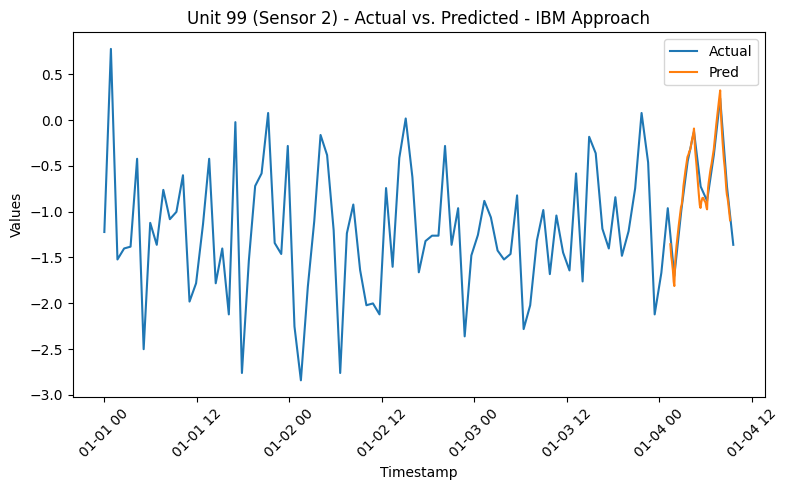

RMSE for Unit 99 - sensor_2: 0.2096578341033822
{'train': [0, 8038], 'valid': [7526, 9043], 'test': [8531, 10047]}
10048
Dataset for unit 100 is good


  0%|          | 0/178 [00:00<?, ?it/s]

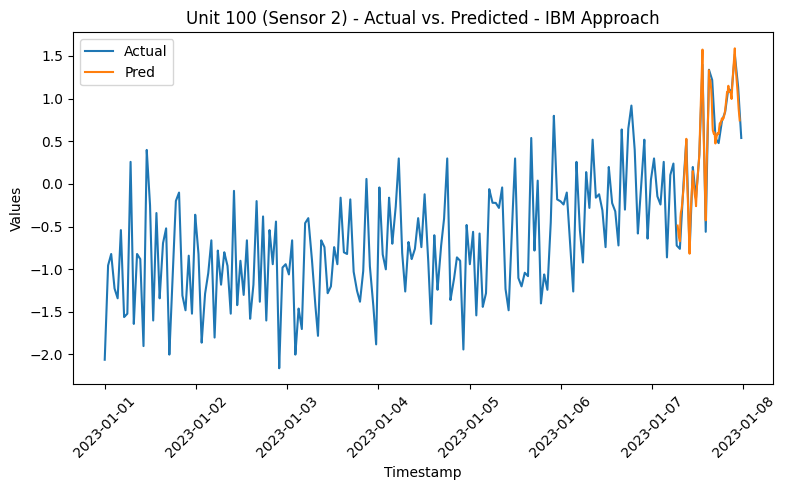

RMSE for Unit 100 - sensor_2: 0.30572025857328455


In [65]:
# Forecast each unit's sensor data
# Assuming the necessary variables (e.g., train_df, context_length, tsp, timestamp_column, target_columns) are defined

unit_list = []
rmse_list = []
split_configs = generate_split_configs(train_df, context_length)

for unit in train_df['unit_number'].unique():
    unit = int(unit)
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index


    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")


    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=False,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    #train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config, fewshot_fraction=fewshot_fraction)
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)
    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=prediction_filter)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    zeroshot_trainer.evaluate(test_dataset)

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1m"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(df_subset[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "sensor_2_prediction", "sensor_2", prediction_filter)
    df.dropna(inplace=True)

    # Plot actual vs. predicted values
    plt.figure(figsize=(8, 5))
    plt.plot(df_subset['timestamp'], df_subset[target_columns], label='Actual', linestyle='-')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-')

    # Add labels and legend
    #plt.axvline(x=df_subset['timestamp'].iloc[test_start_index], color='red', linestyle='--', label='Test Start')
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('Unit {} (Sensor 2) - Actual vs. Predicted - IBM Approach'.format(unit))
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit} - {target_columns[0]}: {rmse}")
    unit_list.append(unit)
    rmse_list.append(rmse)
    

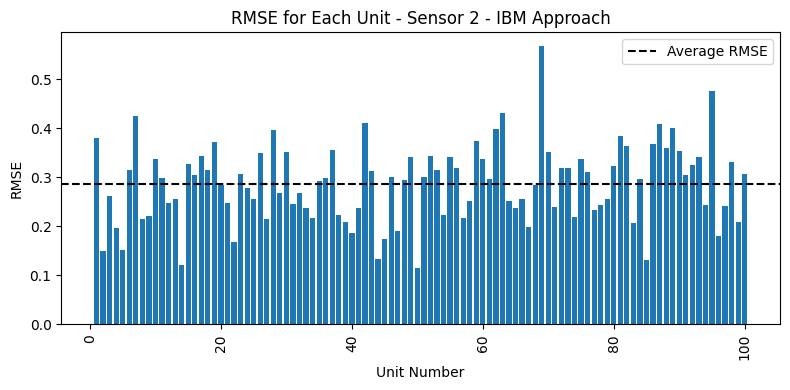

Average RMSE:  0.28705655587330275


In [66]:
plt.figure(figsize=(8,4))
plt.bar(unit_list, rmse_list)
plt.axhline(y=np.mean(rmse_list), color='black', linestyle='--', label='Average RMSE')
plt.xlabel('Unit Number')
plt.ylabel('RMSE')
plt.title('RMSE for Each Unit - Sensor 2 - IBM Approach')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

print("Average RMSE: ", np.mean(rmse_list))